In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(readxl)
# library(rvest)
# library(stringr)
# install.packages('janitor')
# library(janitor)
library(ggplot2)
#options(repr.matrix.max.rows = 50)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Demonstrating that the dataset can be read from the web into R #

In [2]:
# reading a csv file containing the data in processed.cleveland.data, 
# with a row of column names (these names are essentially the column names specified in cleve.mod, under ‘Original atts’, without the stuff in brackets)
options(repr.matrix.max.rows = 25)

cleveland_dataset_web <- read_csv(file = url("https://archive.ics.uci.edu/static/public/45/data.csv"))

# extracting the column names from the very first line of the csv file (because the other files I plan to import do not contain column names)
first_row_contents <- read_csv(file = url("https://archive.ics.uci.edu/static/public/45/data.csv"), n_max = 1) |> names()

# reading a file containing the data in processed.switzerland.data
switzerland_dataset_web <- read_delim(file = url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"), 
                                    delim = ",", col_names = first_row_contents) |>
                        mutate(trestbps = as.numeric(trestbps), chol = as.numeric(chol), fbs = as.numeric(fbs), restecg = as.numeric(restecg), 
                               thalach = as.numeric(thalach), exang = as.numeric(exang), oldpeak = as.numeric(oldpeak),
                               slope = as.numeric(slope), ca = as.numeric(ca), thal = as.numeric(thal))

# reading a file containing the data in processed.va.data
virginia_dataset_web <- read_delim(file = url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"), 
                                    delim = ",", col_names = first_row_contents) |>
                        mutate(trestbps = as.numeric(trestbps), chol = as.numeric(chol), fbs = as.numeric(fbs), 
                               thalach = as.numeric(thalach), exang = as.numeric(exang), oldpeak = as.numeric(oldpeak),
                               slope = as.numeric(slope), ca = as.numeric(ca), thal = as.numeric(thal))

# reading a file containing the data in reprocessed.hungarian.data
reprocessed_hungarian_dataset_web <- read_delim(file = url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"), 
                                    delim = " ", col_names = first_row_contents) |>
                        mutate(trestbps = as.numeric(trestbps), chol = as.numeric(chol), fbs = as.numeric(fbs), restecg = as.numeric(restecg), 
                               thalach = as.numeric(thalach), exang = as.numeric(exang), oldpeak = as.numeric(oldpeak),
                               slope = as.numeric(slope), ca = as.numeric(ca), thal = as.numeric(thal))

# reading the file titled heart-disease.names, because I will reference information when justifying some of the decisions we made as far as tidying the data is concerned
notes_about_data <- read_file(file = url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names"))

global_dataset <- bind_rows(cleveland_dataset_web, switzerland_dataset_web, virginia_dataset_web, reprocessed_hungarian_dataset_web)

global_dataset_first_25_rows <- global_dataset |> slice(1:25)
global_dataset_first_25_rows

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to retrieve the full column specification for this data

Here we convert the value -9 into NA, because of this excerpt from the file named heart-disease.names: 
> "Missing Attribute Values: Several.  Distinguished with value -9.0."

In [3]:
na_matrix <- global_dataset == "-9"

is.na(global_dataset) <- na_matrix

Here is the code that prints out the contents of *heart-disease.names*, in case you'd like to confirm

In [4]:
line_separated_notes <- notes_about_data |> strsplit(split = "\n") |>
      unlist()
cat(line_separated_notes[238])      

9. Missing Attribute Values: Several.  Distinguished with value -9.0.

# Cleaning and wrangling the data into a tidy format #

## 1) summarizing the data in at least one table using only training data: ##

In [5]:
# we now try to create
# a table that reports 
# the number of healthy and sick observations,
# the number of rows with missing values for healthy and sick observations,
# the percentage of healthy and sick observations,
# the average ages of healthy and sick observations, 
# the average resting blood pressures of healthy and sick observations,
# the average cholesterol of healthy and sick observations,
# average max heart rate of healthy and sick observations,
# average ST depression induced by exercise relative to rest for healthy and sick observations,
# and the average number of vessels colored by flourosopy for healthy and sick observations,
# for each class in our dataset

In [6]:
global_dataset <- as_tibble(global_dataset)

# The description of the num attribute in heart-disease.names doesn't match the possible values of num in any of the 4 data files we're using in our analysis.

# here are the discrepancies:

# a) under the subsection of heart-disease.names titled "7. Attribute Information", 
# it states that num can either be 0 or 1, but looking through our data, values of num in the range 0:4 can be found within the first 25 rows of global_dataset

# b) under the subsection of heart-disease.names titled "7. Attribute Information", it is also stated that 0 indicates < 50% diameter narrowing,
# while 1 indicates > 50% diameter narrowing. However, it contradicts the description of num under the subsection of heart-disease.names titled "4. Relevant Information",
# which states that "Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0)".
 
# As such, we strongly believe that 0 does not indicate < 50% diameter narrowing, and 1 does not indicate > 50% diameter narrowing.

# We proceed with our analysis based on the understanding that value 0 indicates absence of heart disease, while values 1, 2, 3, 4 indicate presence of heart disease

global_dataset |>
      rename(Class = num) |>
      mutate(Class = as.factor(Class)) |>
      mutate(Class = fct_recode(Class, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4")) |>
      mutate(row_contains_na = (is.na(age) | is.na(sex) | is.na(cp) | is.na(trestbps) | is.na(chol) | is.na(fbs) | is.na(restecg) | is.na(thalach) | is.na(exang) | is.na(oldpeak) | is.na(slope) | is.na(ca) | is.na(thal))) |>
      group_by(Class) |>
      summarize(
         count = n(), 
         num_rows_with_na = sum(row_contains_na),
         percentage = count / nrow(global_dataset) * 100,
         average_age = mean(age, na.rm = TRUE),
         avg_resting_bp = mean(trestbps, na.rm = TRUE),
         avg_cholestorol = mean(chol, na.rm = TRUE),
         avg_max_hr = mean(thalach, na.rm = TRUE),
         avg_oldpeak = mean(oldpeak, na.rm = TRUE),
         avg_ca = mean(ca, na.rm = TRUE)
         )

global_dataset |>
      pivot_longer(cols = c(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)) |>
      rename(Class = num) |>
      mutate(Class = as.factor(Class)) |>
      mutate(Class = fct_recode(Class, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4")) |>
      group_by(Class, name) |>
      summarize(
         num_missing_values = sum(is.na(value))
      ) |> 
      group_by(Class) |>
      summarize(num_cols_with_na = sum(num_missing_values > 0))

Class   count num_rows_with_na percentage average_age avg_resting_bp
1 healthy 411   251              44.67391   50.54745    129.9130      
2 sick    509   370              55.32609   55.90373    133.9787      
  avg_cholestorol avg_max_hr avg_oldpeak avg_ca   
1 227.9056        148.8005   0.4182051   0.3313253
2 176.4799        128.2616   1.2626068   1.1319444

`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.


Class   num_cols_with_na
1 healthy  9              
2 sick    10

## Explaining what the values of num_rows_with_na (third column of the first summary tibble) <br> and <br> num_cols_with_na (second column of the second summary table) represent ##

The third column of the first summary tibble conveys that, out of all the rows in the dataset, 

439 of the rows corresponding to healthy observations have NA values, 

while 475 of rows corresponding to sick observations have NA values;

On the other hand,

The second column of the second summary tibble conveys that, out of all the rows in the dataset, 

the NA values in the rows corresponding to healthy observations are all located in exactly 9 of the 14 columns,

while the NA values in the rows corresponding to sick observations are also located in exactly 10 of the 14 columns.

# Justification for the datasets we chose to use: #

After reading through lines 109 - 124 of **heart-disease.names**, 
it became clear to us that, although the data collected during numerous heart disease diagnoses could be partitioned into 76 attributes, only 14 of the attributes were eventually used in experiments revolving heart diseases. Since the objective of our project is to predict whether or not an observed individual may or may not have heart disease, we decided that we would also choose from the data files that consisted of only the 14 attributes that had been used by researchers.
As such, our choices for data files were narrowed down to:
> processed.cleveland.data
>
> data.csv 
>
> processed.hungarian.data
>
> processed.switzerland.data
>
> processed.va.data
>
> reprocessed.hungarian.data

Deciding between processed.cleveland.data and data.csv:
> we saw that data.csv essentially contained the same information as processed.cleveland.data, 
> but data.csv also contained the names of the 14 attributes in the correct order. Therefore, 
> we decided to go with data.csv over processed.cleveland.data

Deciding between processed.hungarian.data and reprocessed.hungarian.data
> we saw that both files were identical save for the fact that the missing values in processed.hungarian.data were represented with a "?".
> As such, we decided to go with reprocessed.hungarian.data over processed.hungarian.data

In [7]:
# preparing the dataset for the code that generates visualizations
global_dataset <- global_dataset |>


      mutate(sex = as_factor(sex)) |>
      mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>


      mutate(cp = as_factor(cp)) |>
      mutate(cp = fct_recode(cp, "typical angina" = "1", "atypical angina" = "2", "non-anginal pain" = "3", "asymptomatic" = "4")) |>


      mutate(fbs = as_factor(fbs)) |>
      mutate(fbs = fct_recode(fbs, "true" = "1", "false" = "0")) |>      


      mutate(restecg = as_factor(restecg)) |>
      mutate(restecg = fct_recode(restecg, "normal" = "0", "ST-T wave abnormality" = "1", "left ventricular hypertrophy" = "2")) |>


      mutate(exang = as_factor(exang)) |>
      mutate(exang = fct_recode(exang, "yes" = "1", "no" = "0")) |>


      mutate(slope = as_factor(slope)) |>
      mutate(slope = fct_recode(slope, "upsloping" = "1", "flat" = "2", "downsloping" = "3")) |>
      

      mutate(thal = as_factor(thal)) |>
      mutate(thal = fct_recode(thal, "normal" = "3", "fixed" = "6", "reversable" = "7")) |>


      mutate(num = as.factor(num)) |>
      mutate(num = fct_recode(num, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4"))

In [8]:
options(repr.matrix.max.rows = 2)
global_dataset <- global_dataset |>
      rename(Age = age, Sex = sex, "Chest_Pain_Type" = cp, "Resting_Blood_Pressure" = trestbps, Cholesterol = chol, "Fasting_blood_sugar_over_120_mg/dl" = fbs,
      "Resting_ecg_results" = restecg, "Max_heart_rate" = thalach, "Exercise_induced_angina" = exang, "ST_depression_induced_by_exercise_relative_to_rest" = oldpeak, 
      "slope_of_the_peak_exercise_ST_segment" = slope, "Number_of_major_vessels_colored_by_flourosopy" = ca, "Thalassemia" = thal, Class = num)

global_dataset

Age Sex  Chest_Pain_Type Resting_Blood_Pressure Cholesterol
1   63  male typical angina  145                    233        
⋮   ⋮   ⋮    ⋮               ⋮                      ⋮          
920 53  male asymptomatic    130                    182        
    Fasting_blood_sugar_over_120_mg/dl Resting_ecg_results         
1   true                               left ventricular hypertrophy
⋮   ⋮                                  ⋮                           
920 false                              normal                      
    Max_heart_rate Exercise_induced_angina
1   150            no                     
⋮   ⋮              ⋮                      
920 148            no                     
    ST_depression_induced_by_exercise_relative_to_rest
1   2.3                                               
⋮   ⋮                                                 
920 0                                                 
    slope_of_the_peak_exercise_ST_segment
1   downsloping                          
⋮   ⋮                                    
920 NA                                   
    Number_of_major_vessels_colored_by_flourosopy Thalassemia Class  
1   0                                             fixed       healthy
⋮   ⋮                                             ⋮           ⋮      
920 NA                                            NA          healthy

In [9]:
## 2) visualizing the data with a plot relevant to the analysis we plan to do using only training data: ##

Warning message:
“Removed 59 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 30 rows containing missing values (`geom_point()`).”


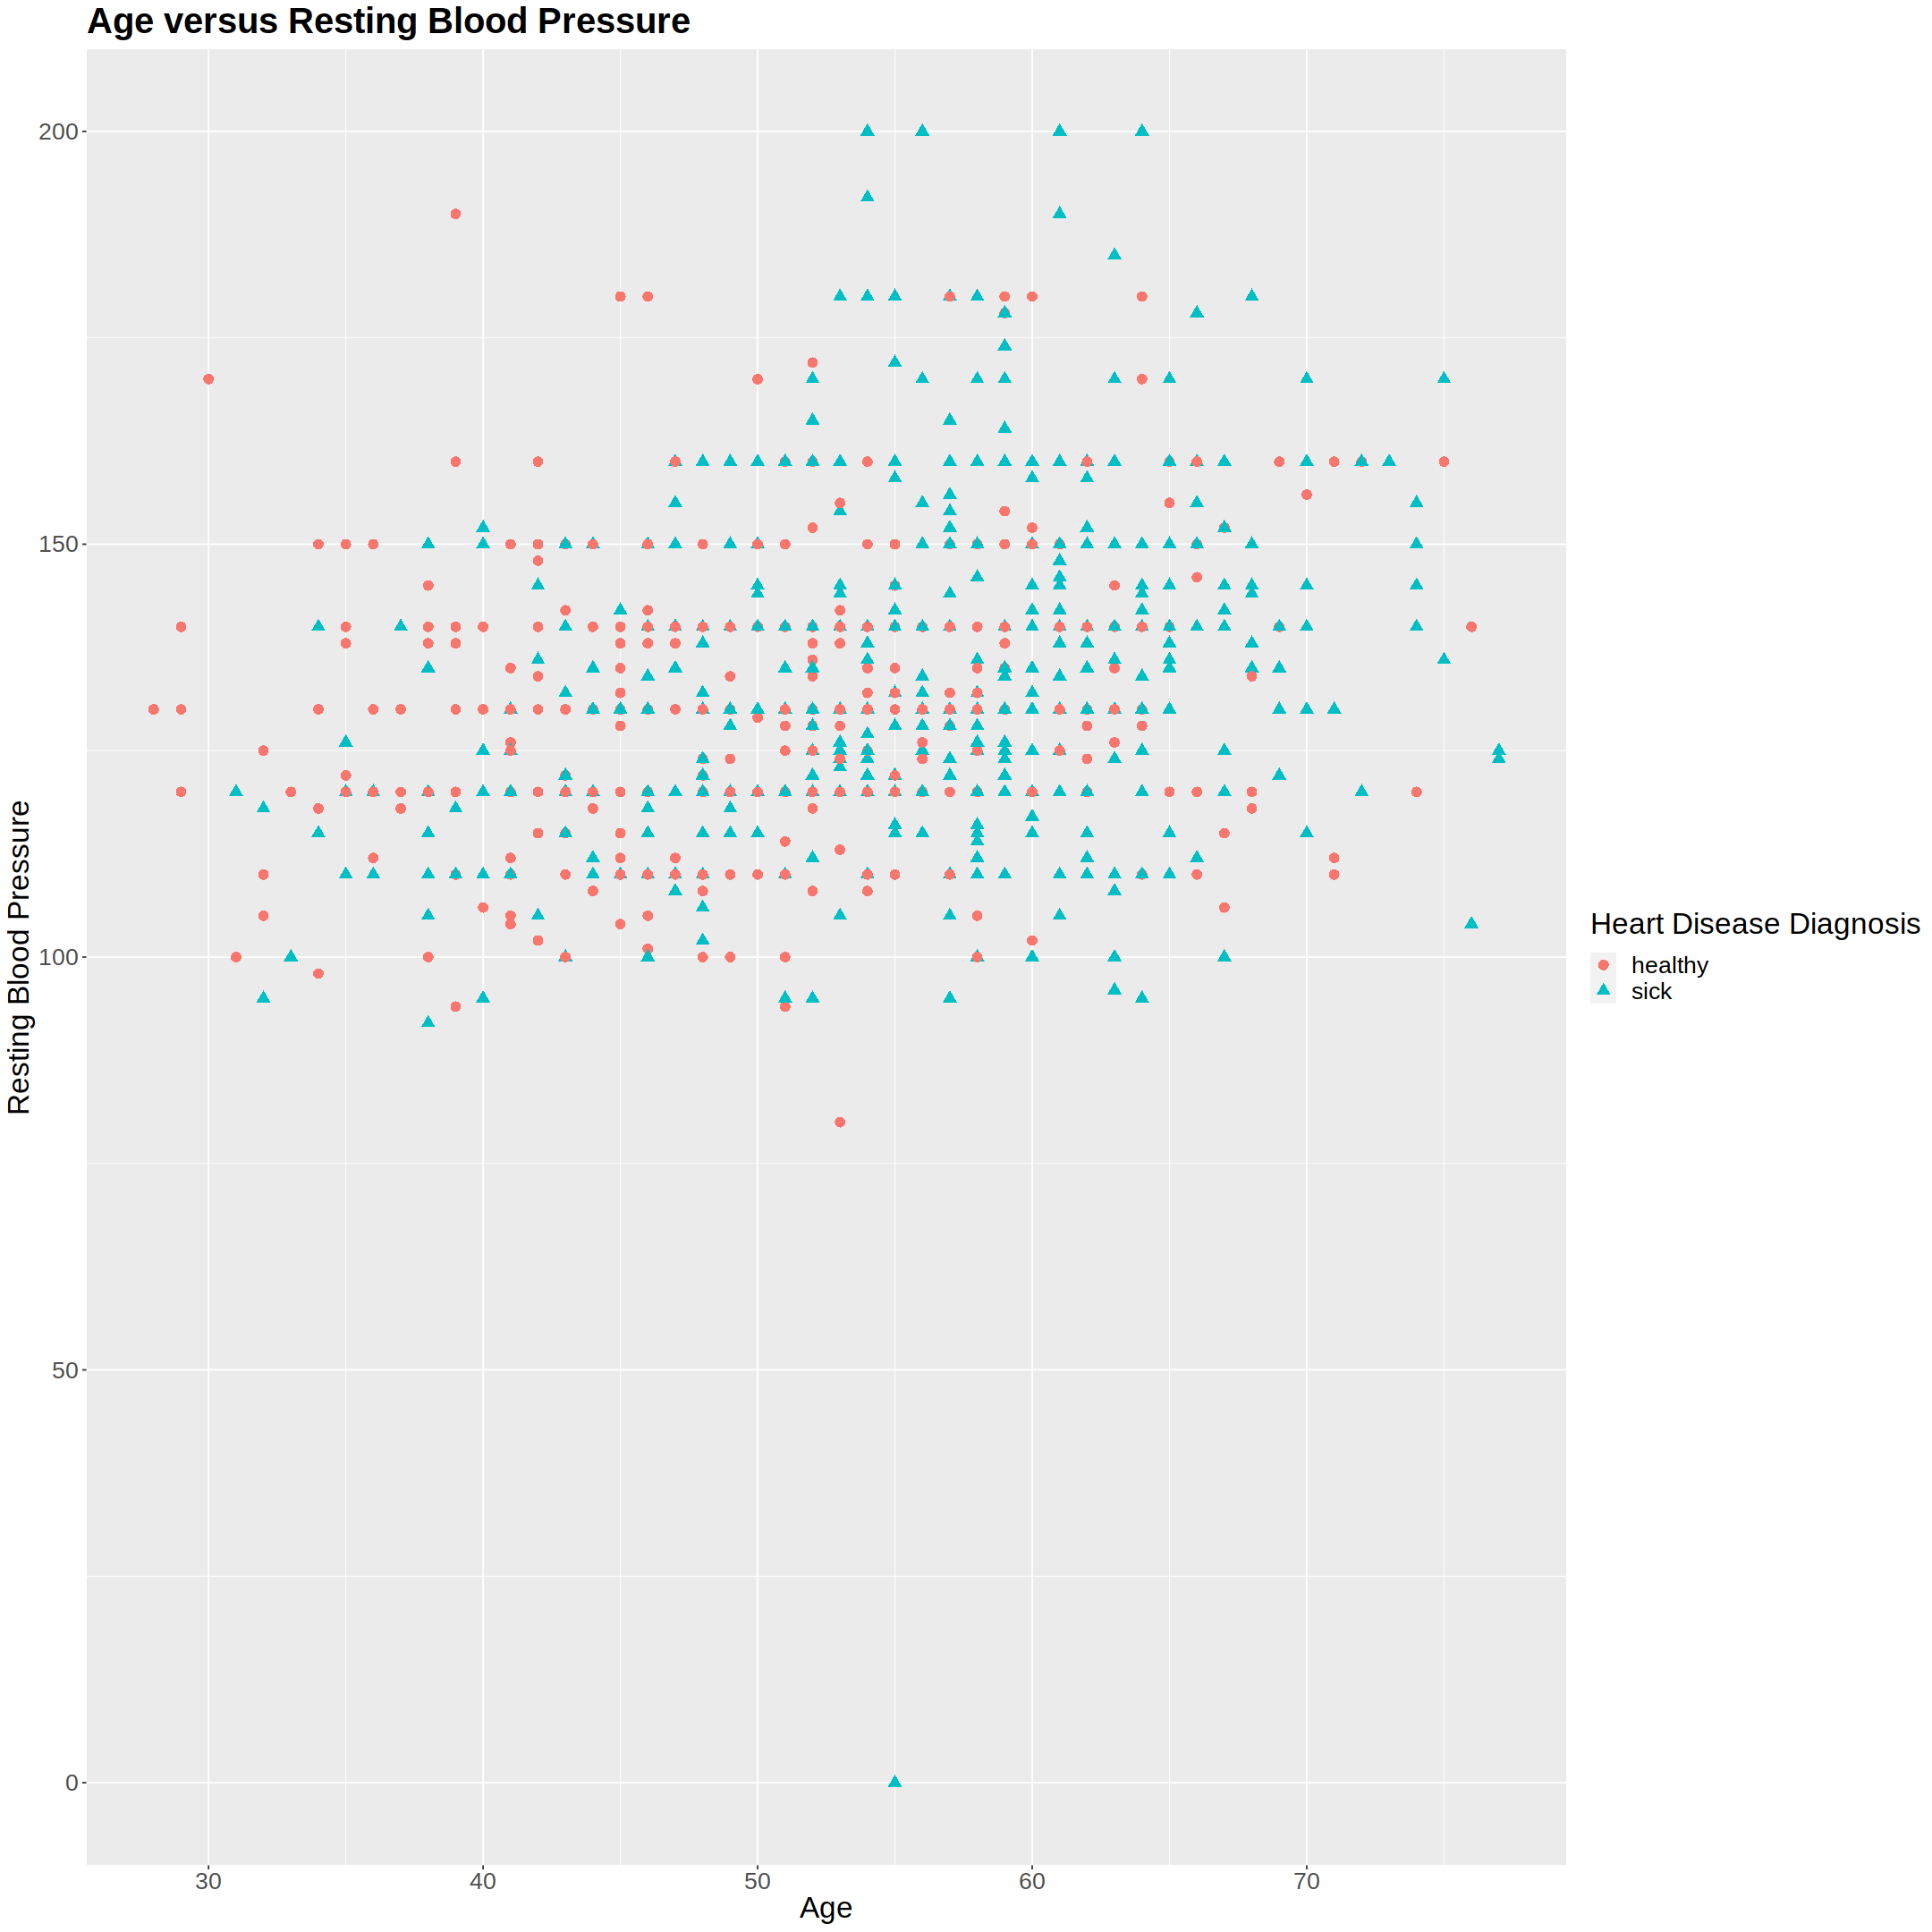

Warning message:
“Removed 55 rows containing missing values (`geom_point()`).”


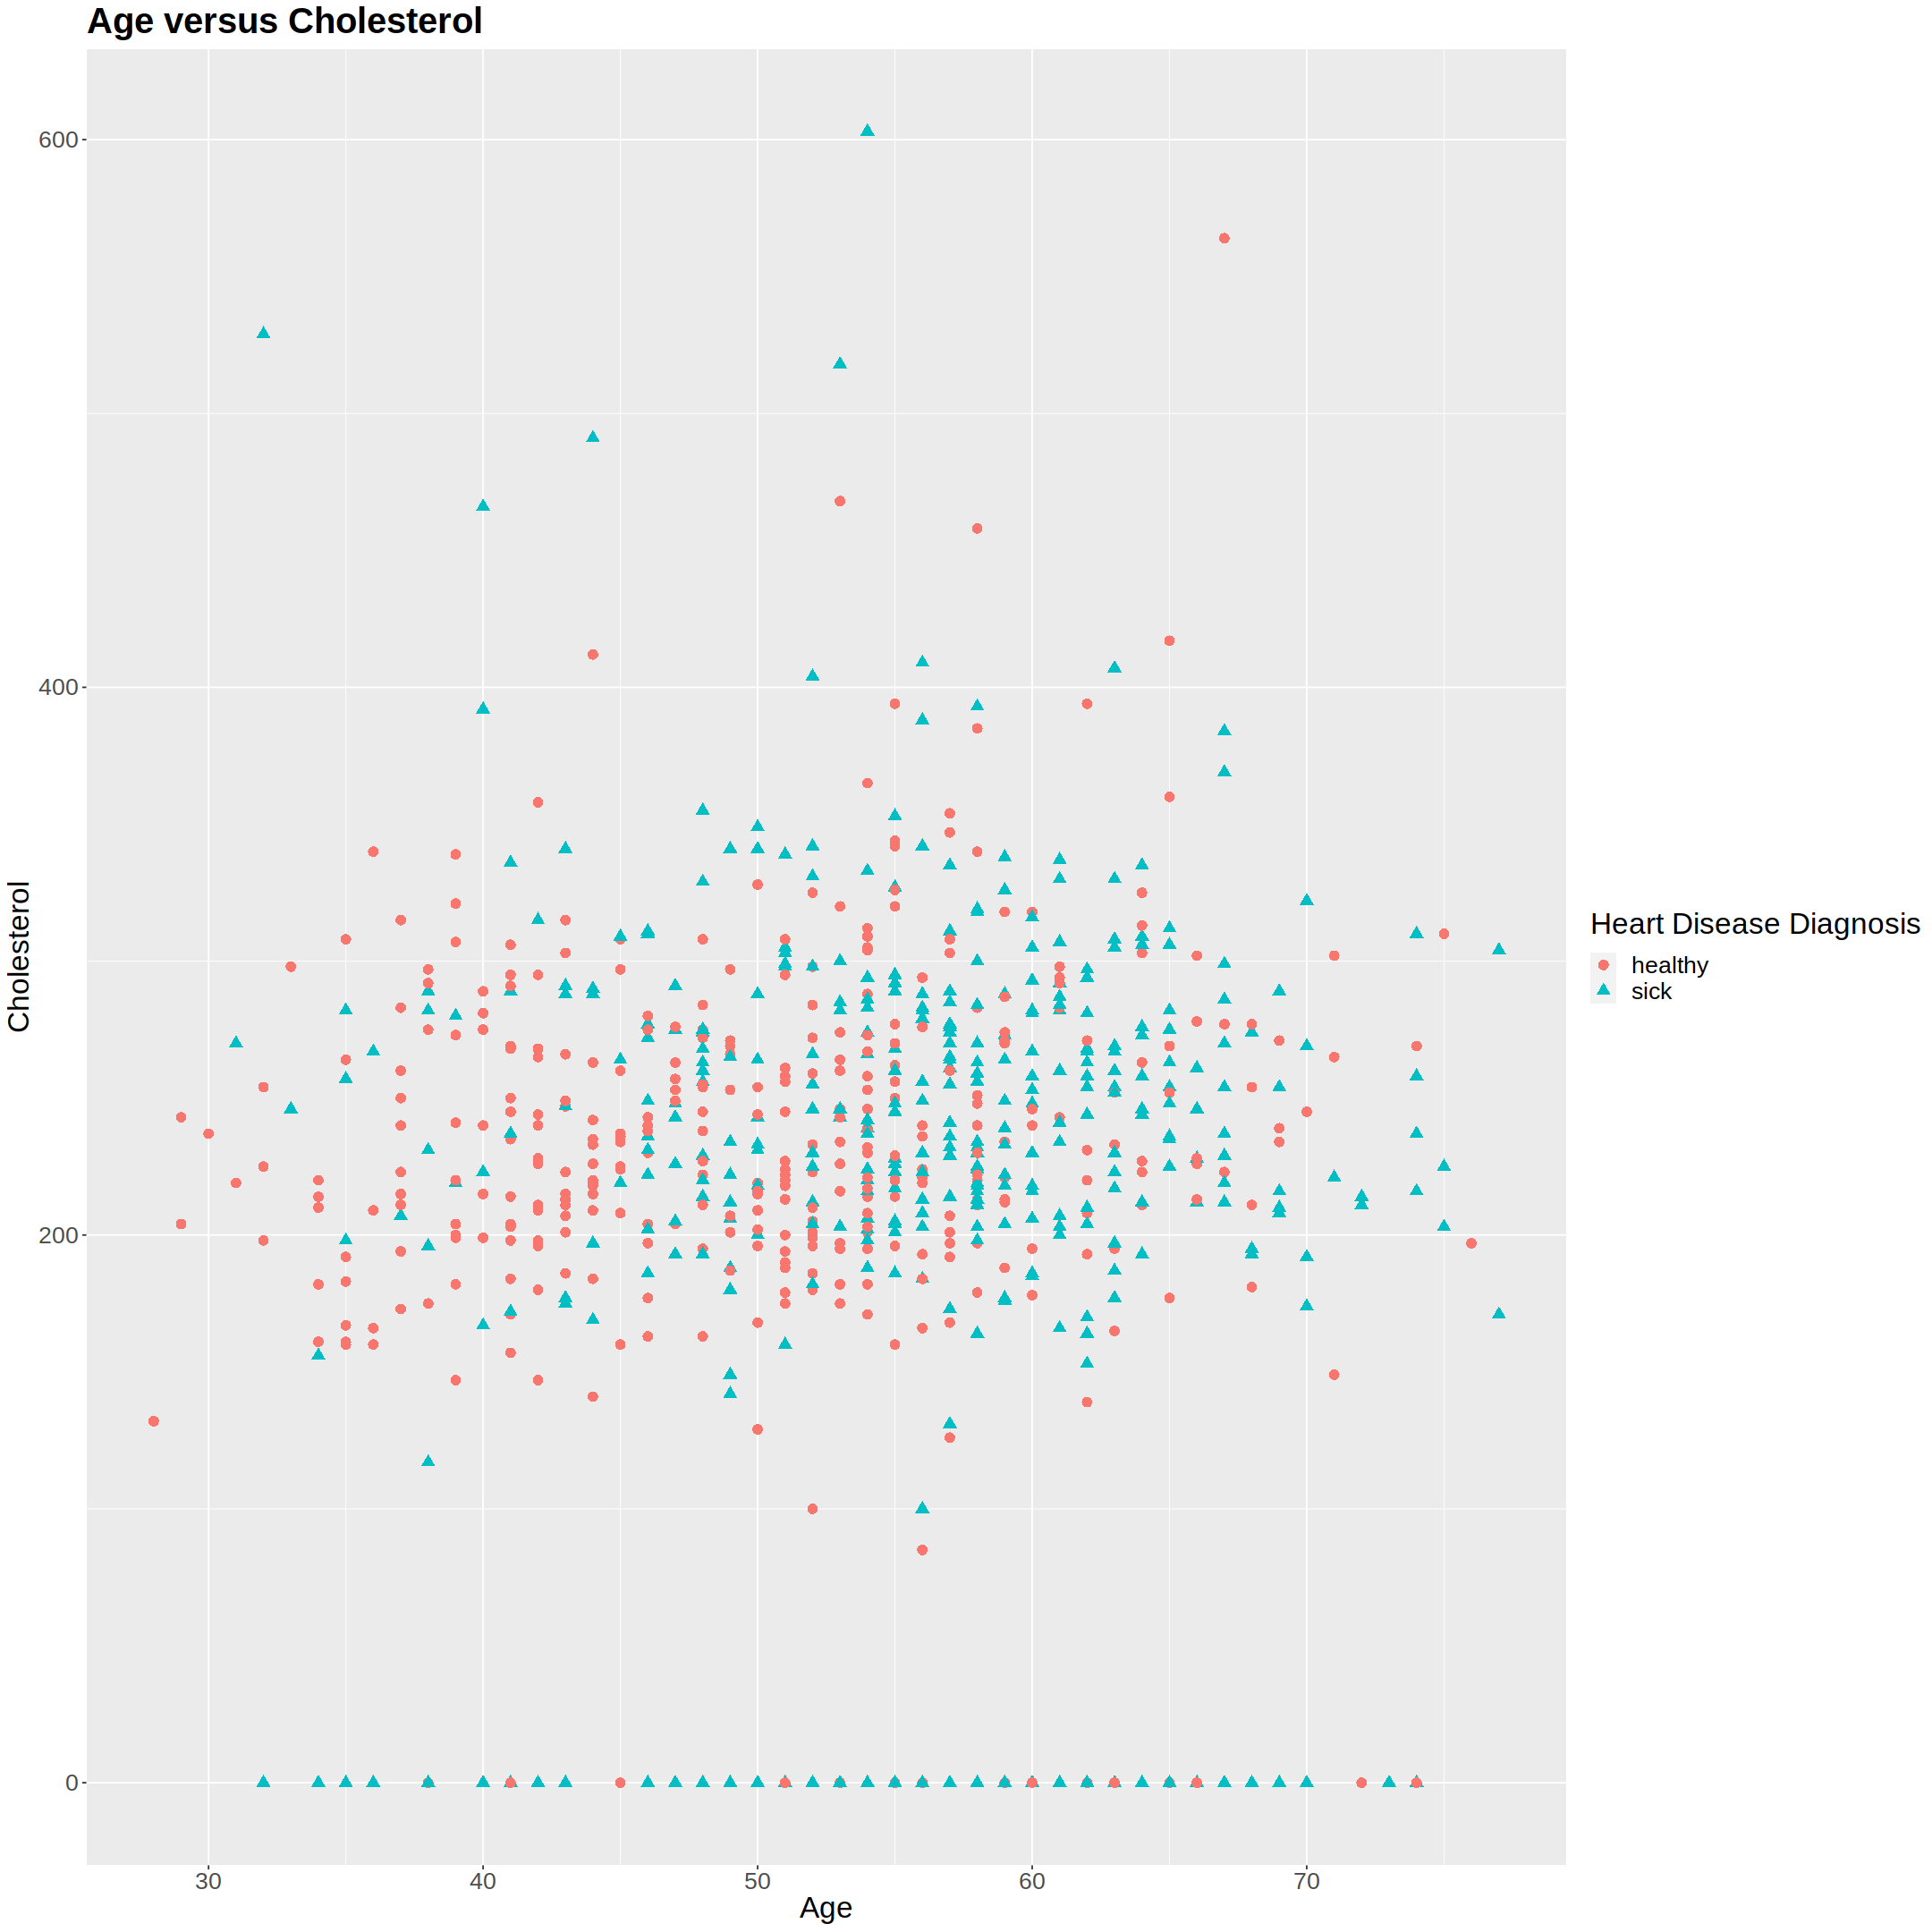

Warning message:
“Removed 62 rows containing missing values (`geom_point()`).”


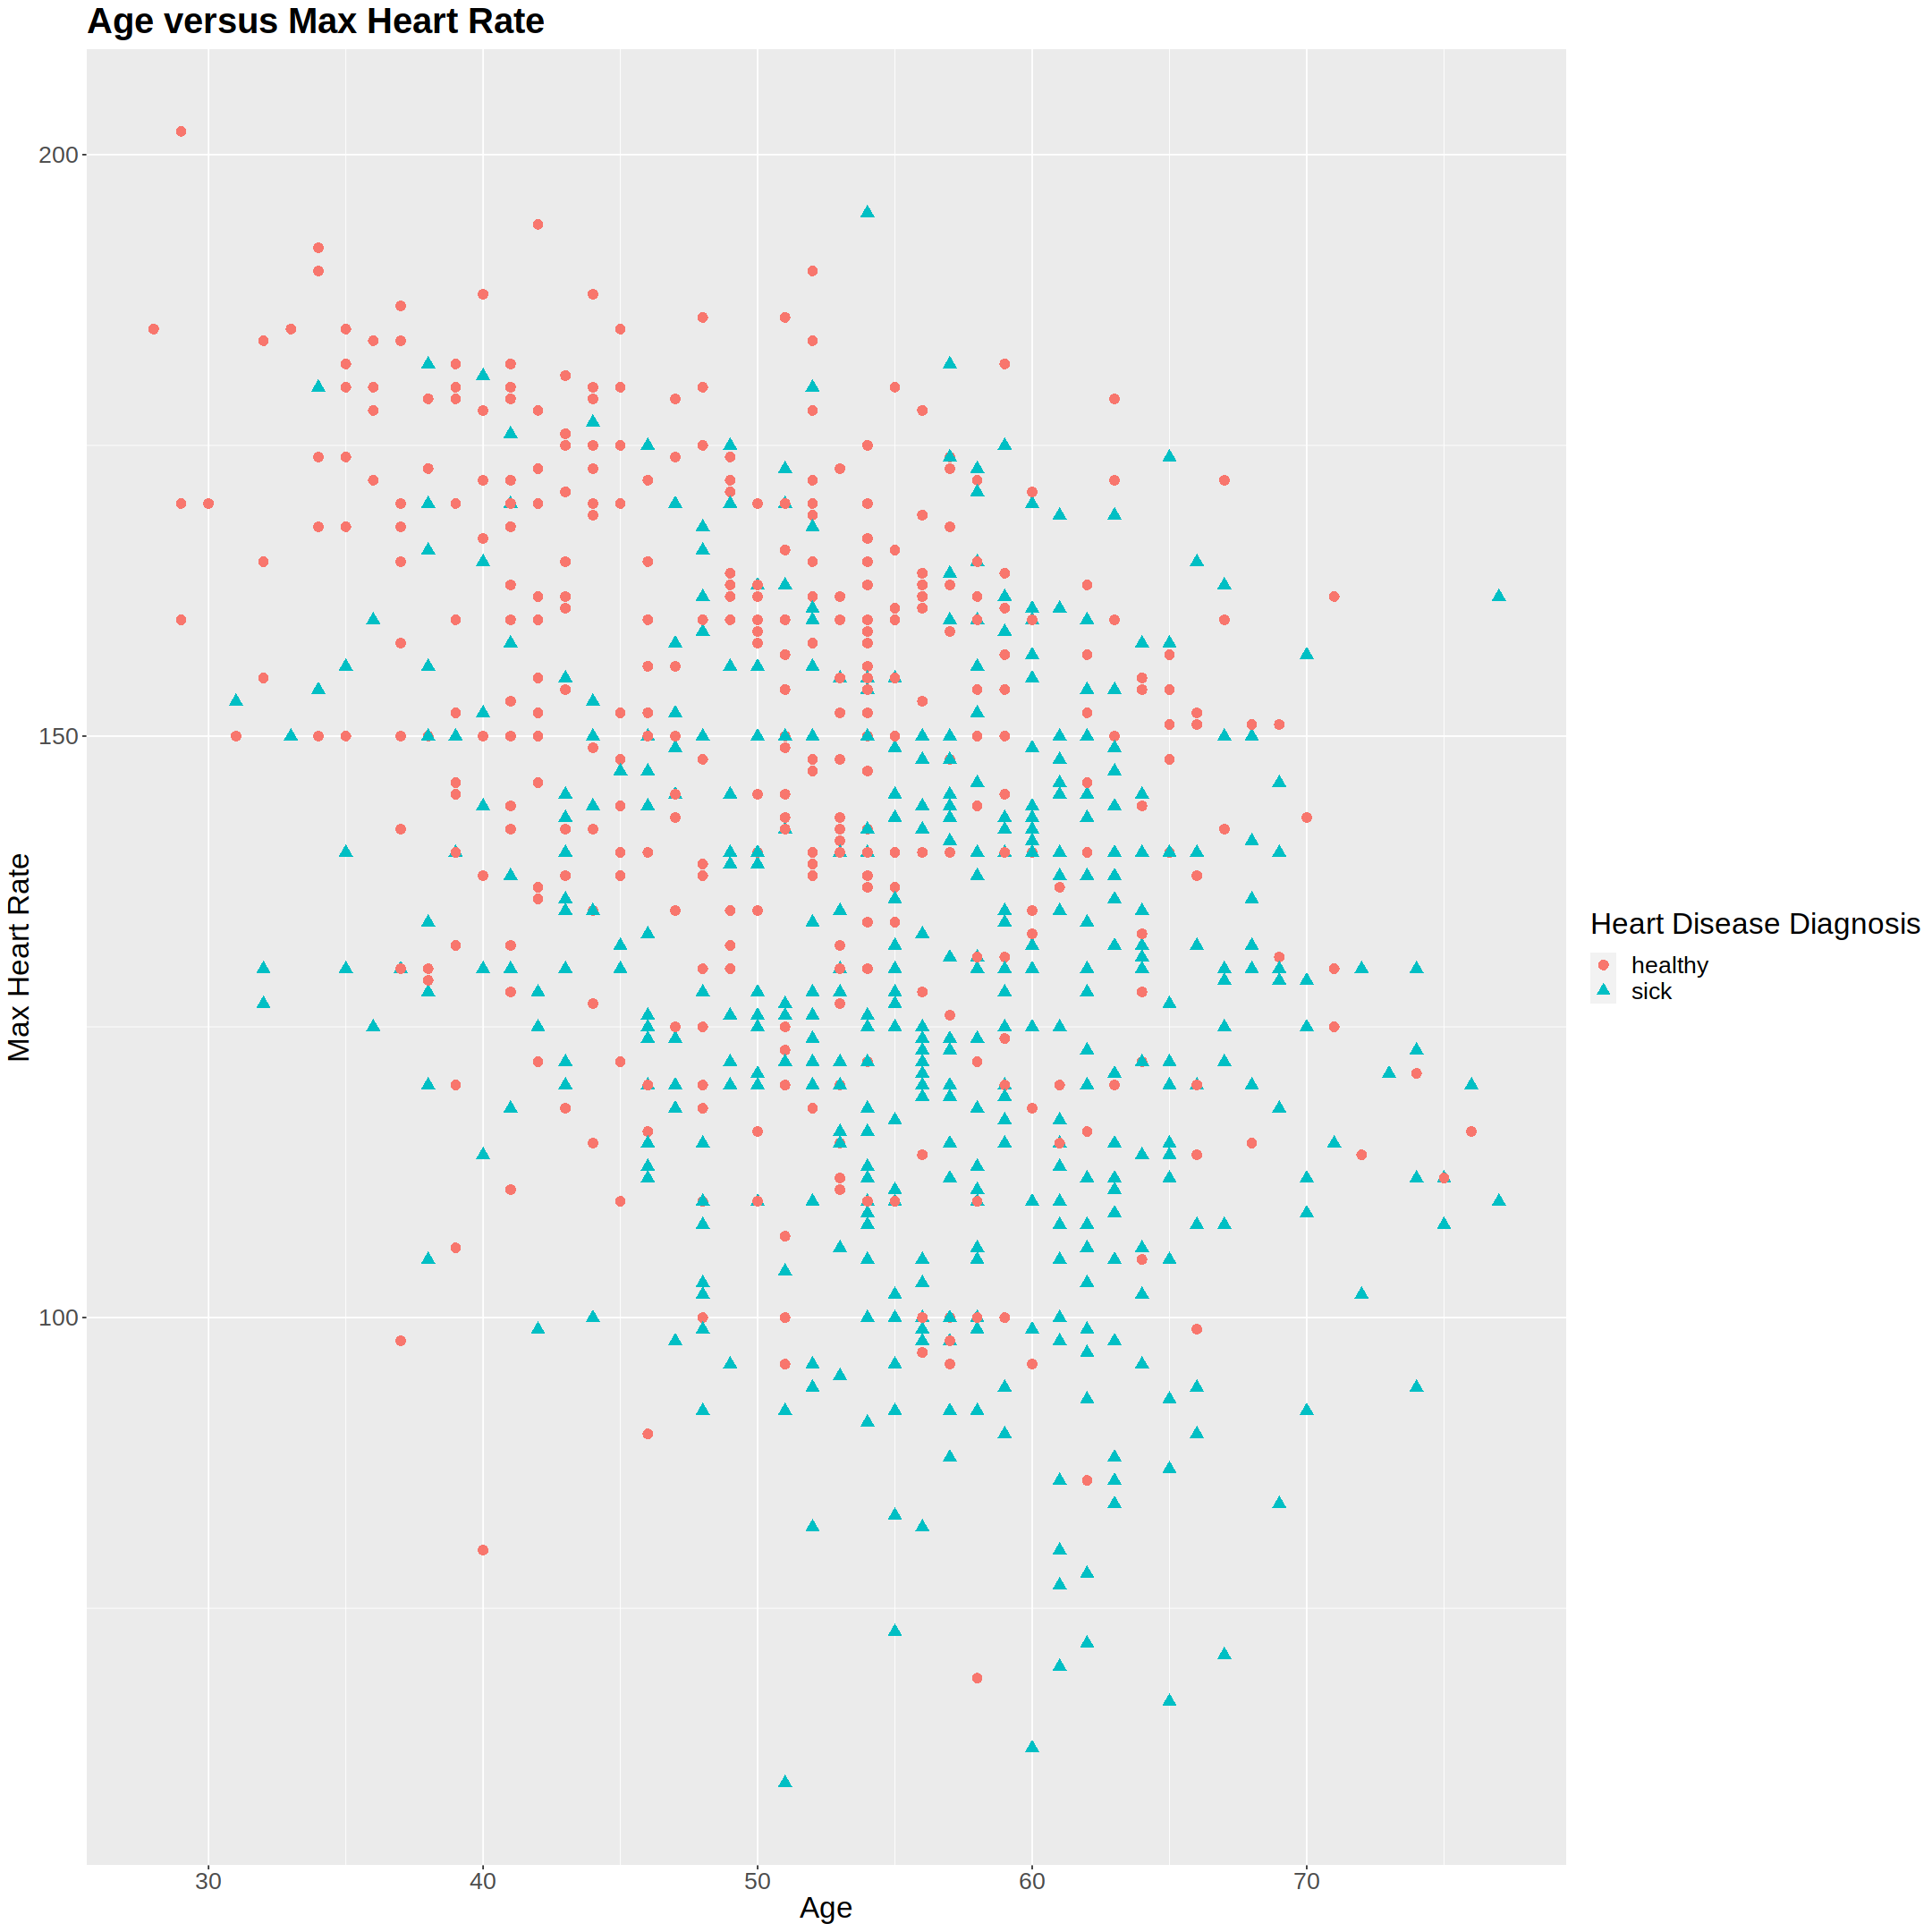

Warning message:
“Removed 610 rows containing missing values (`geom_point()`).”


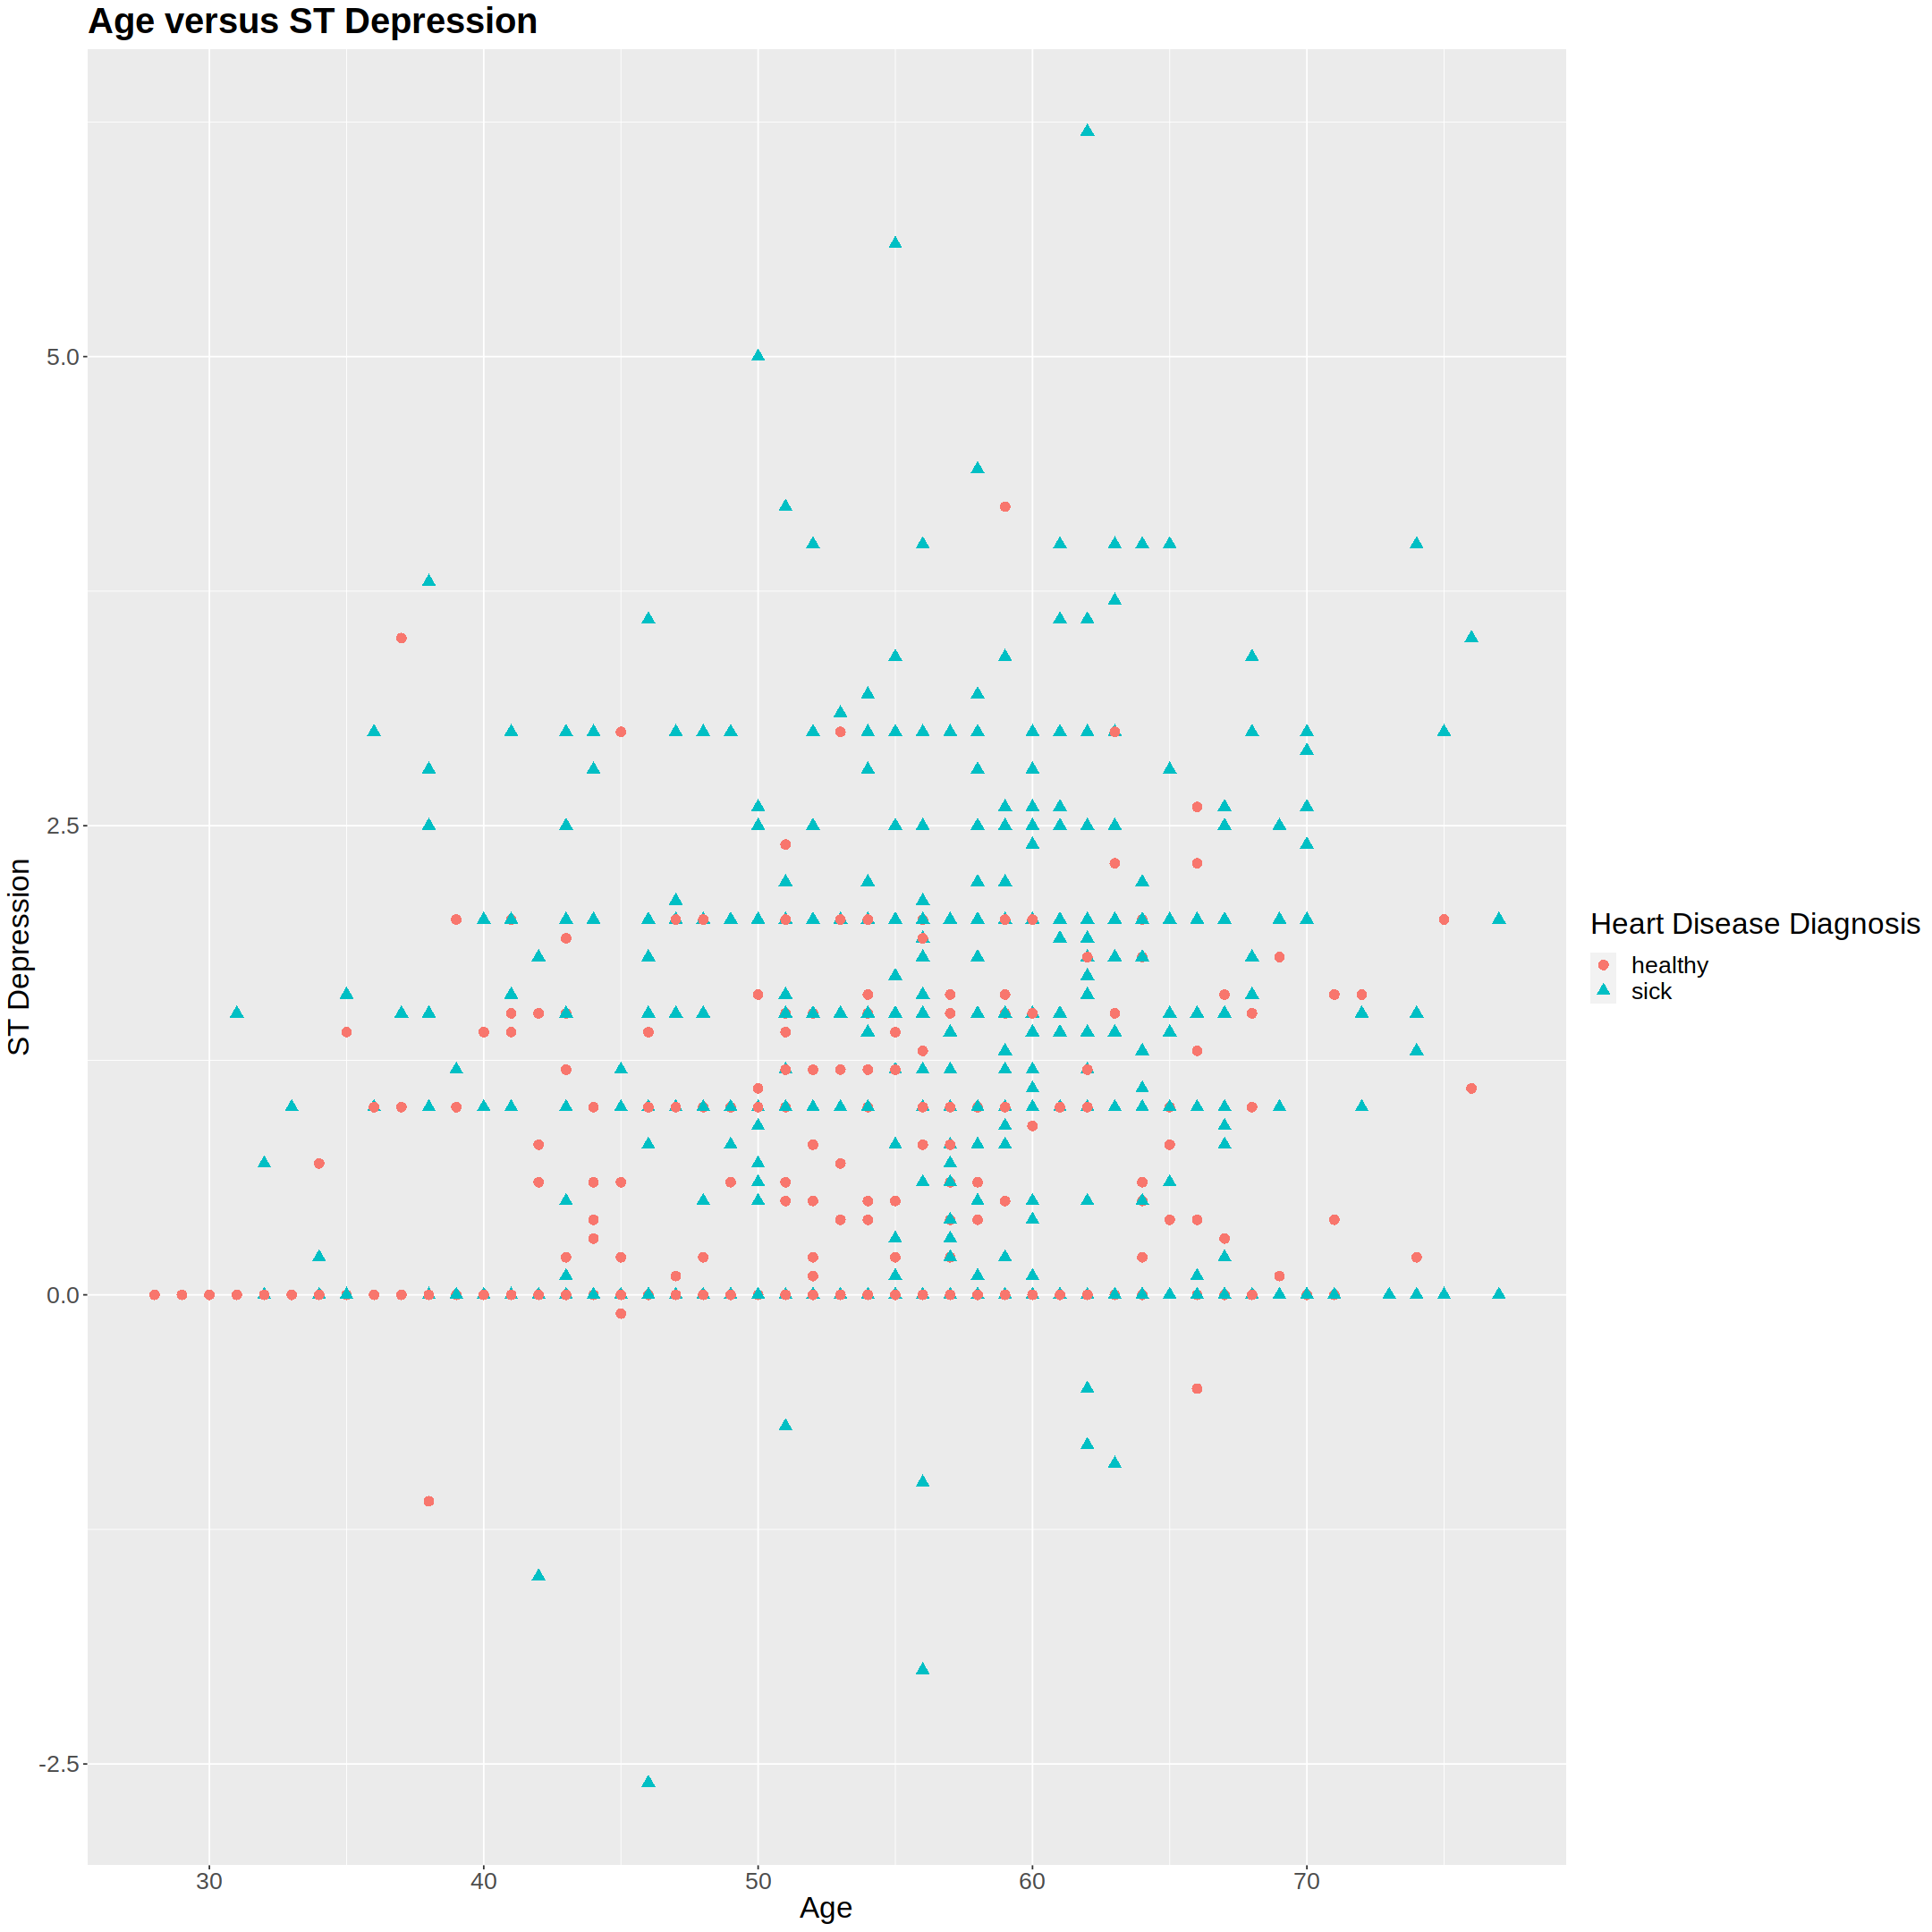

Warning message:
“Removed 86 rows containing missing values (`geom_point()`).”


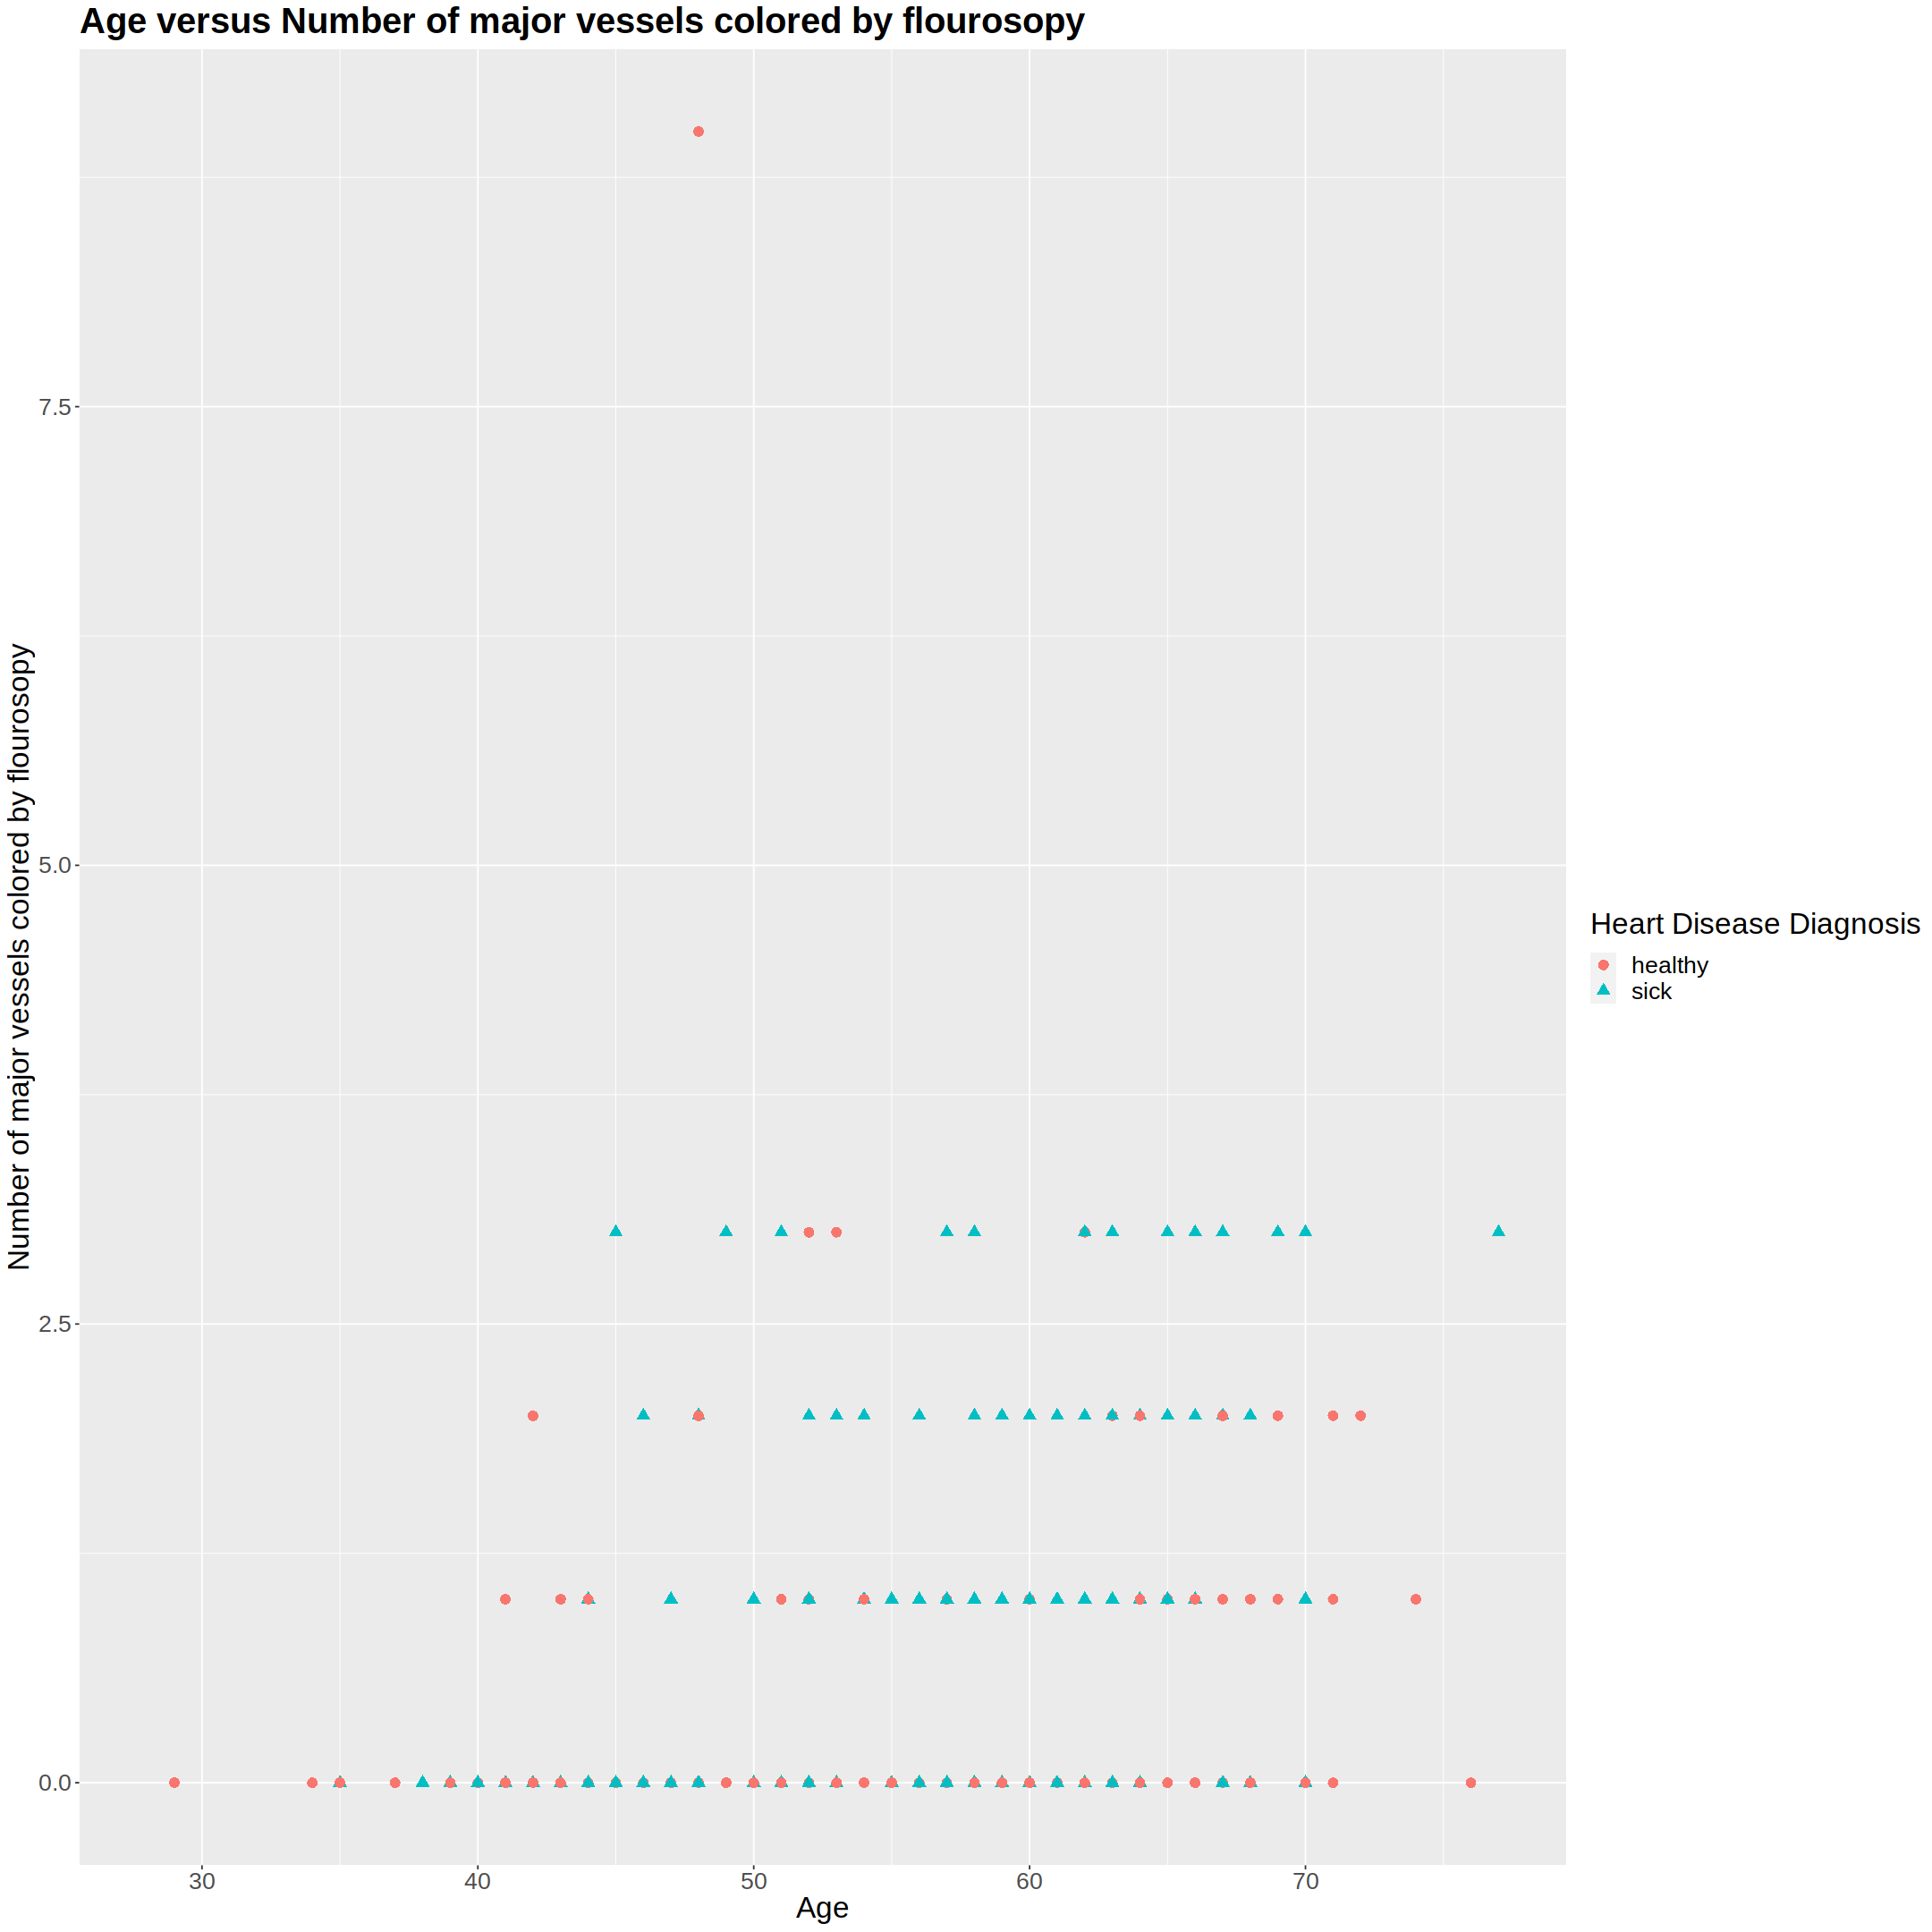

Warning message:
“Removed 59 rows containing missing values (`geom_point()`).”


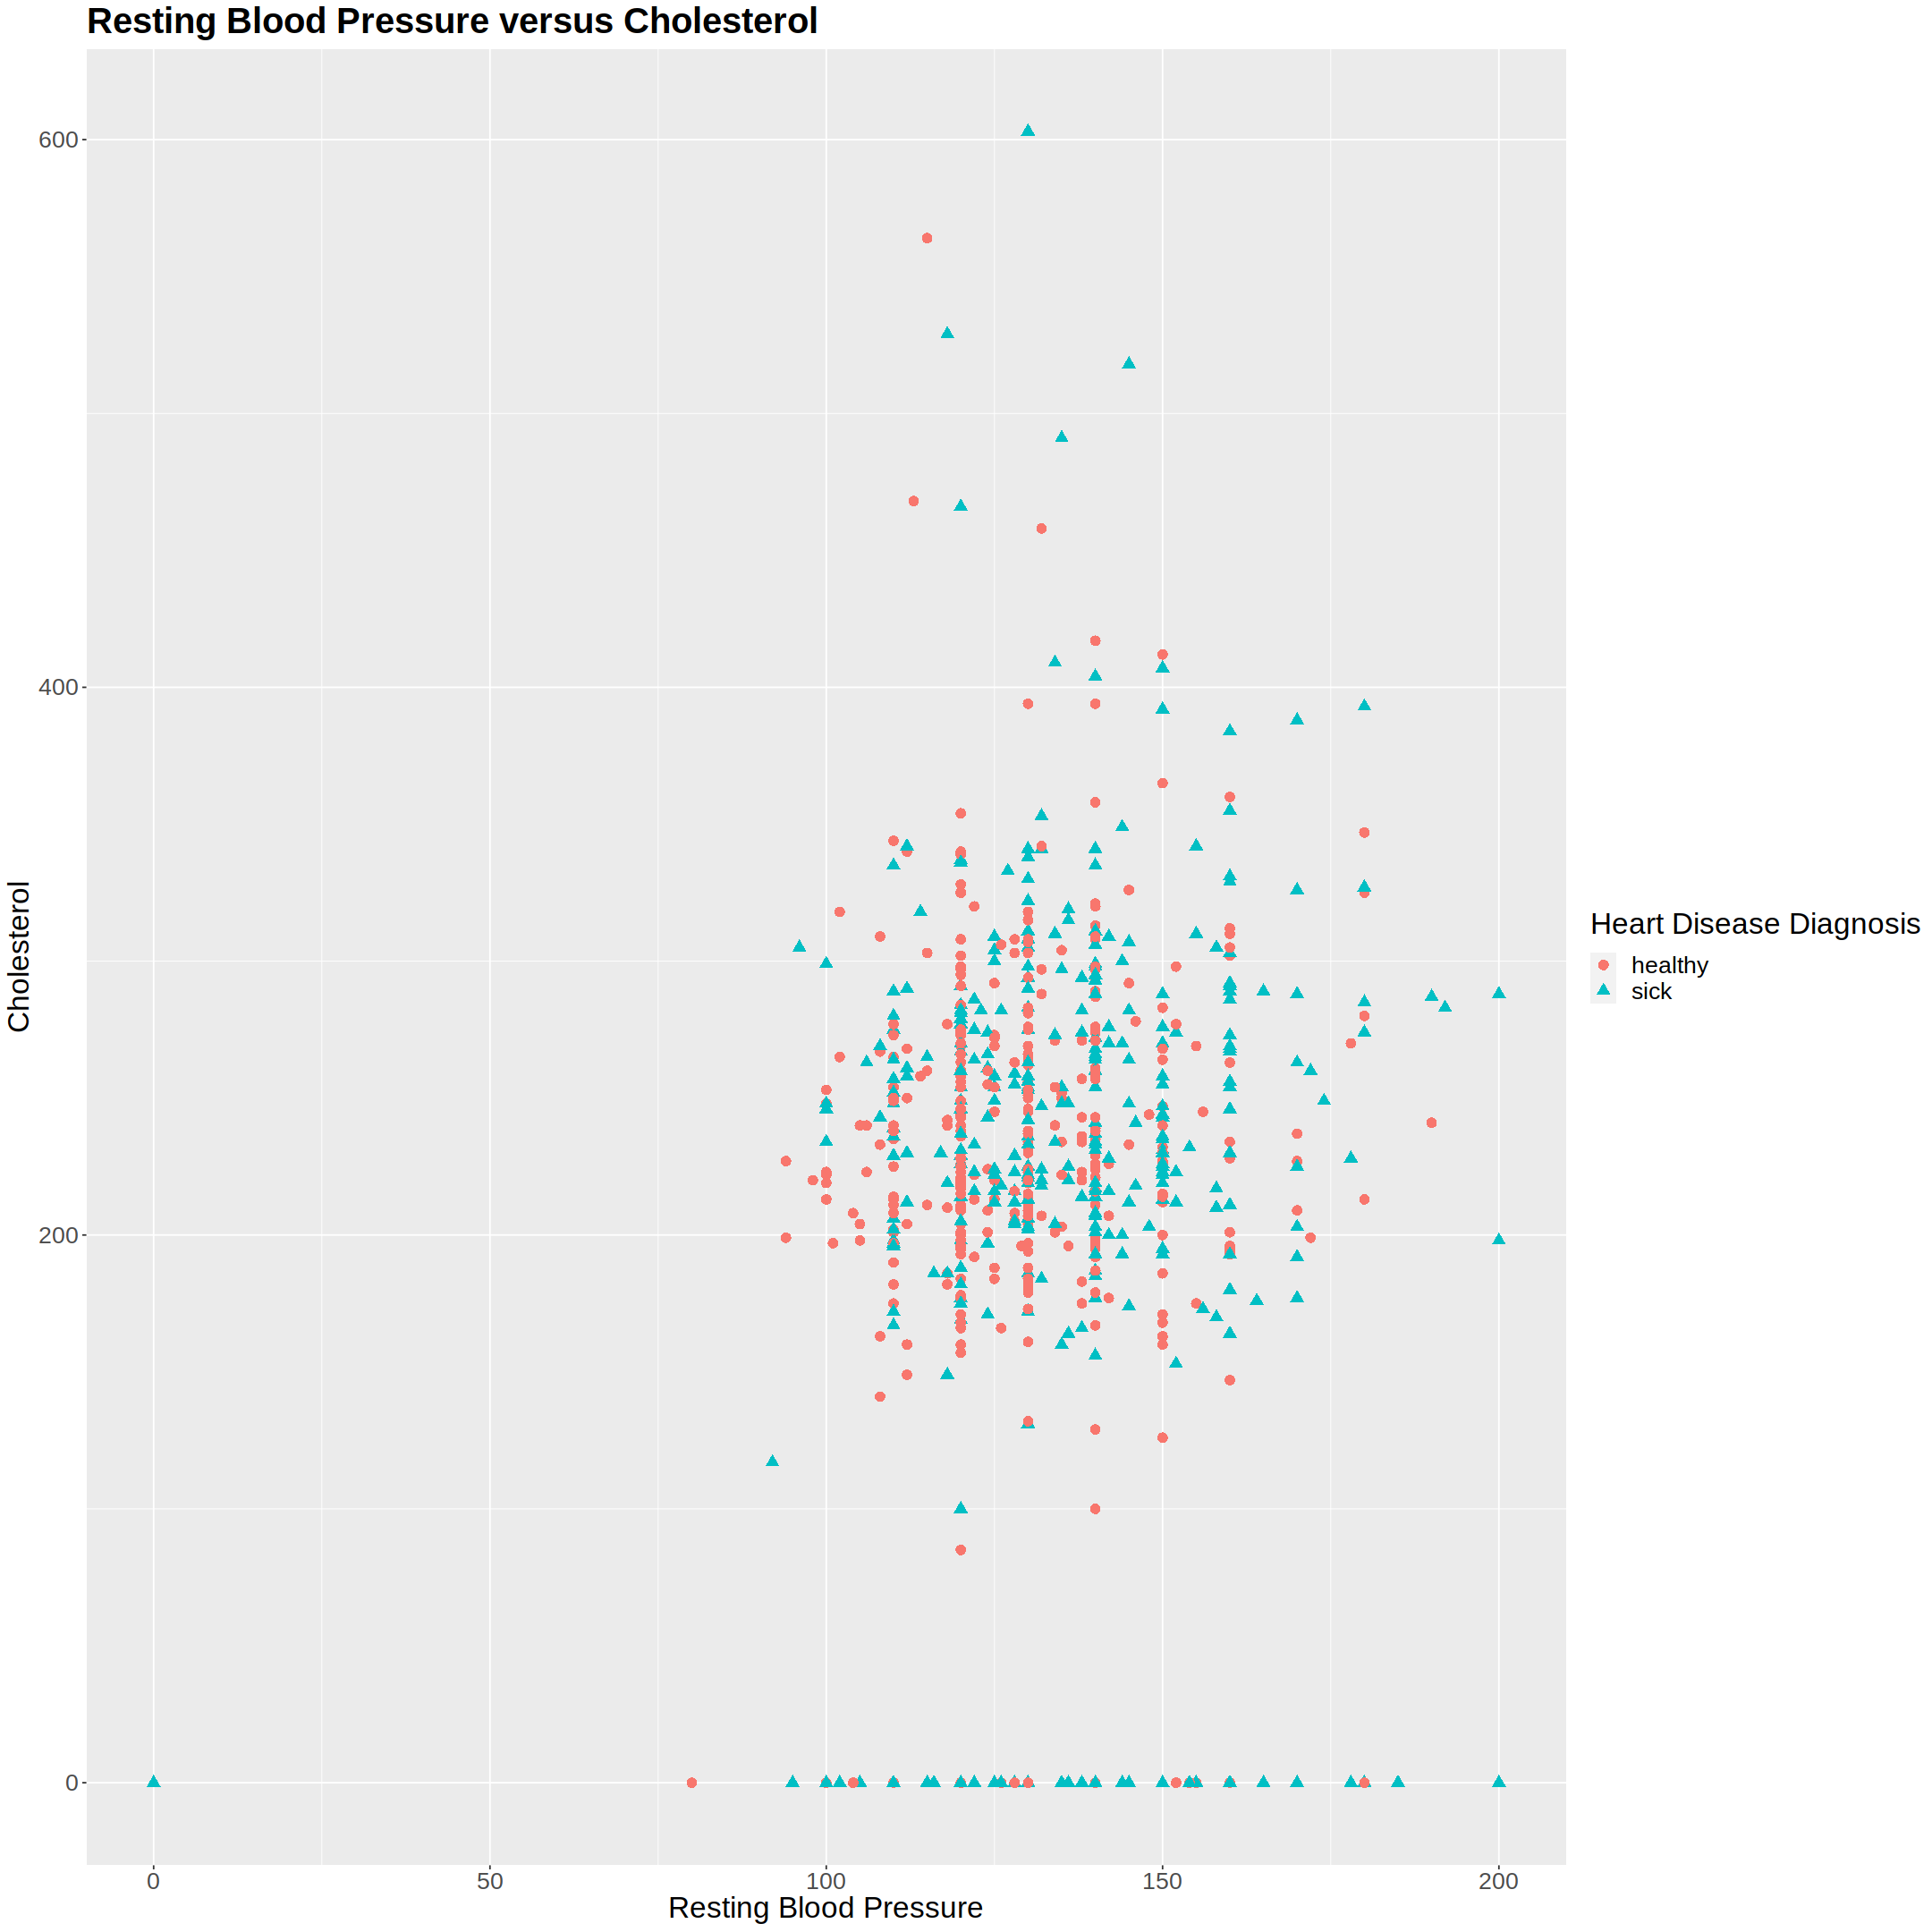

Warning message:
“Removed 66 rows containing missing values (`geom_point()`).”


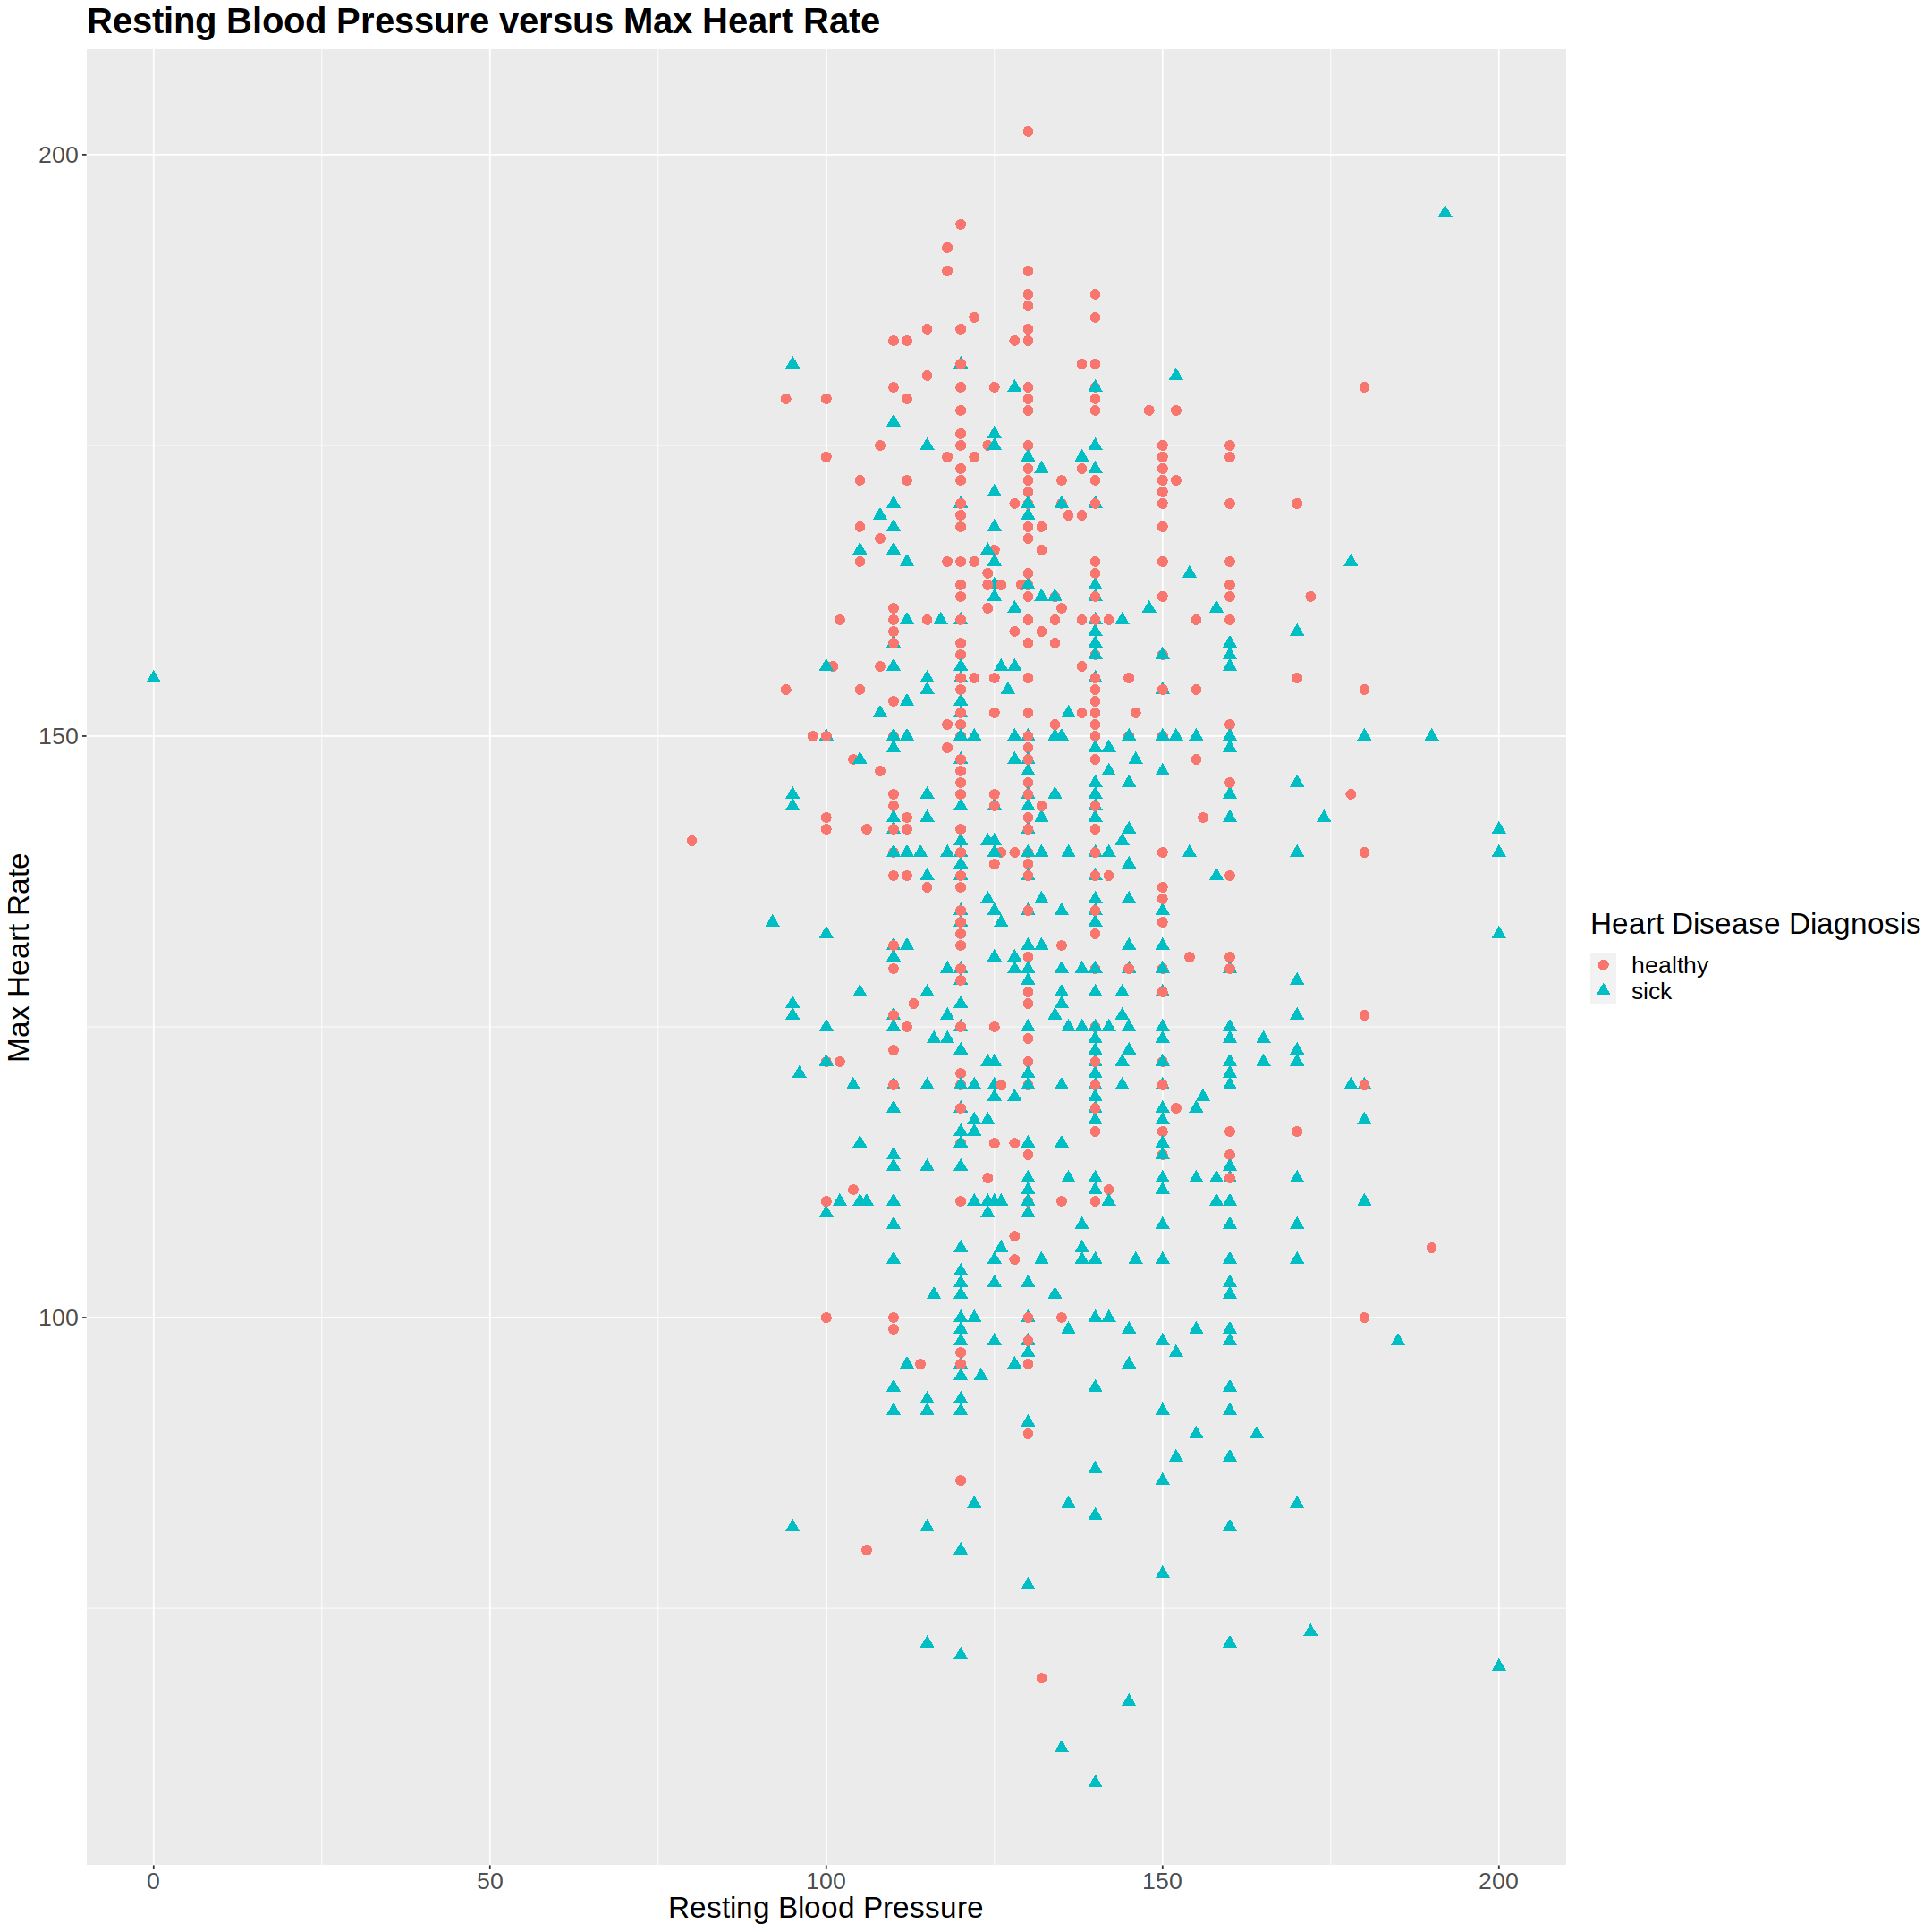

Warning message:
“Removed 610 rows containing missing values (`geom_point()`).”


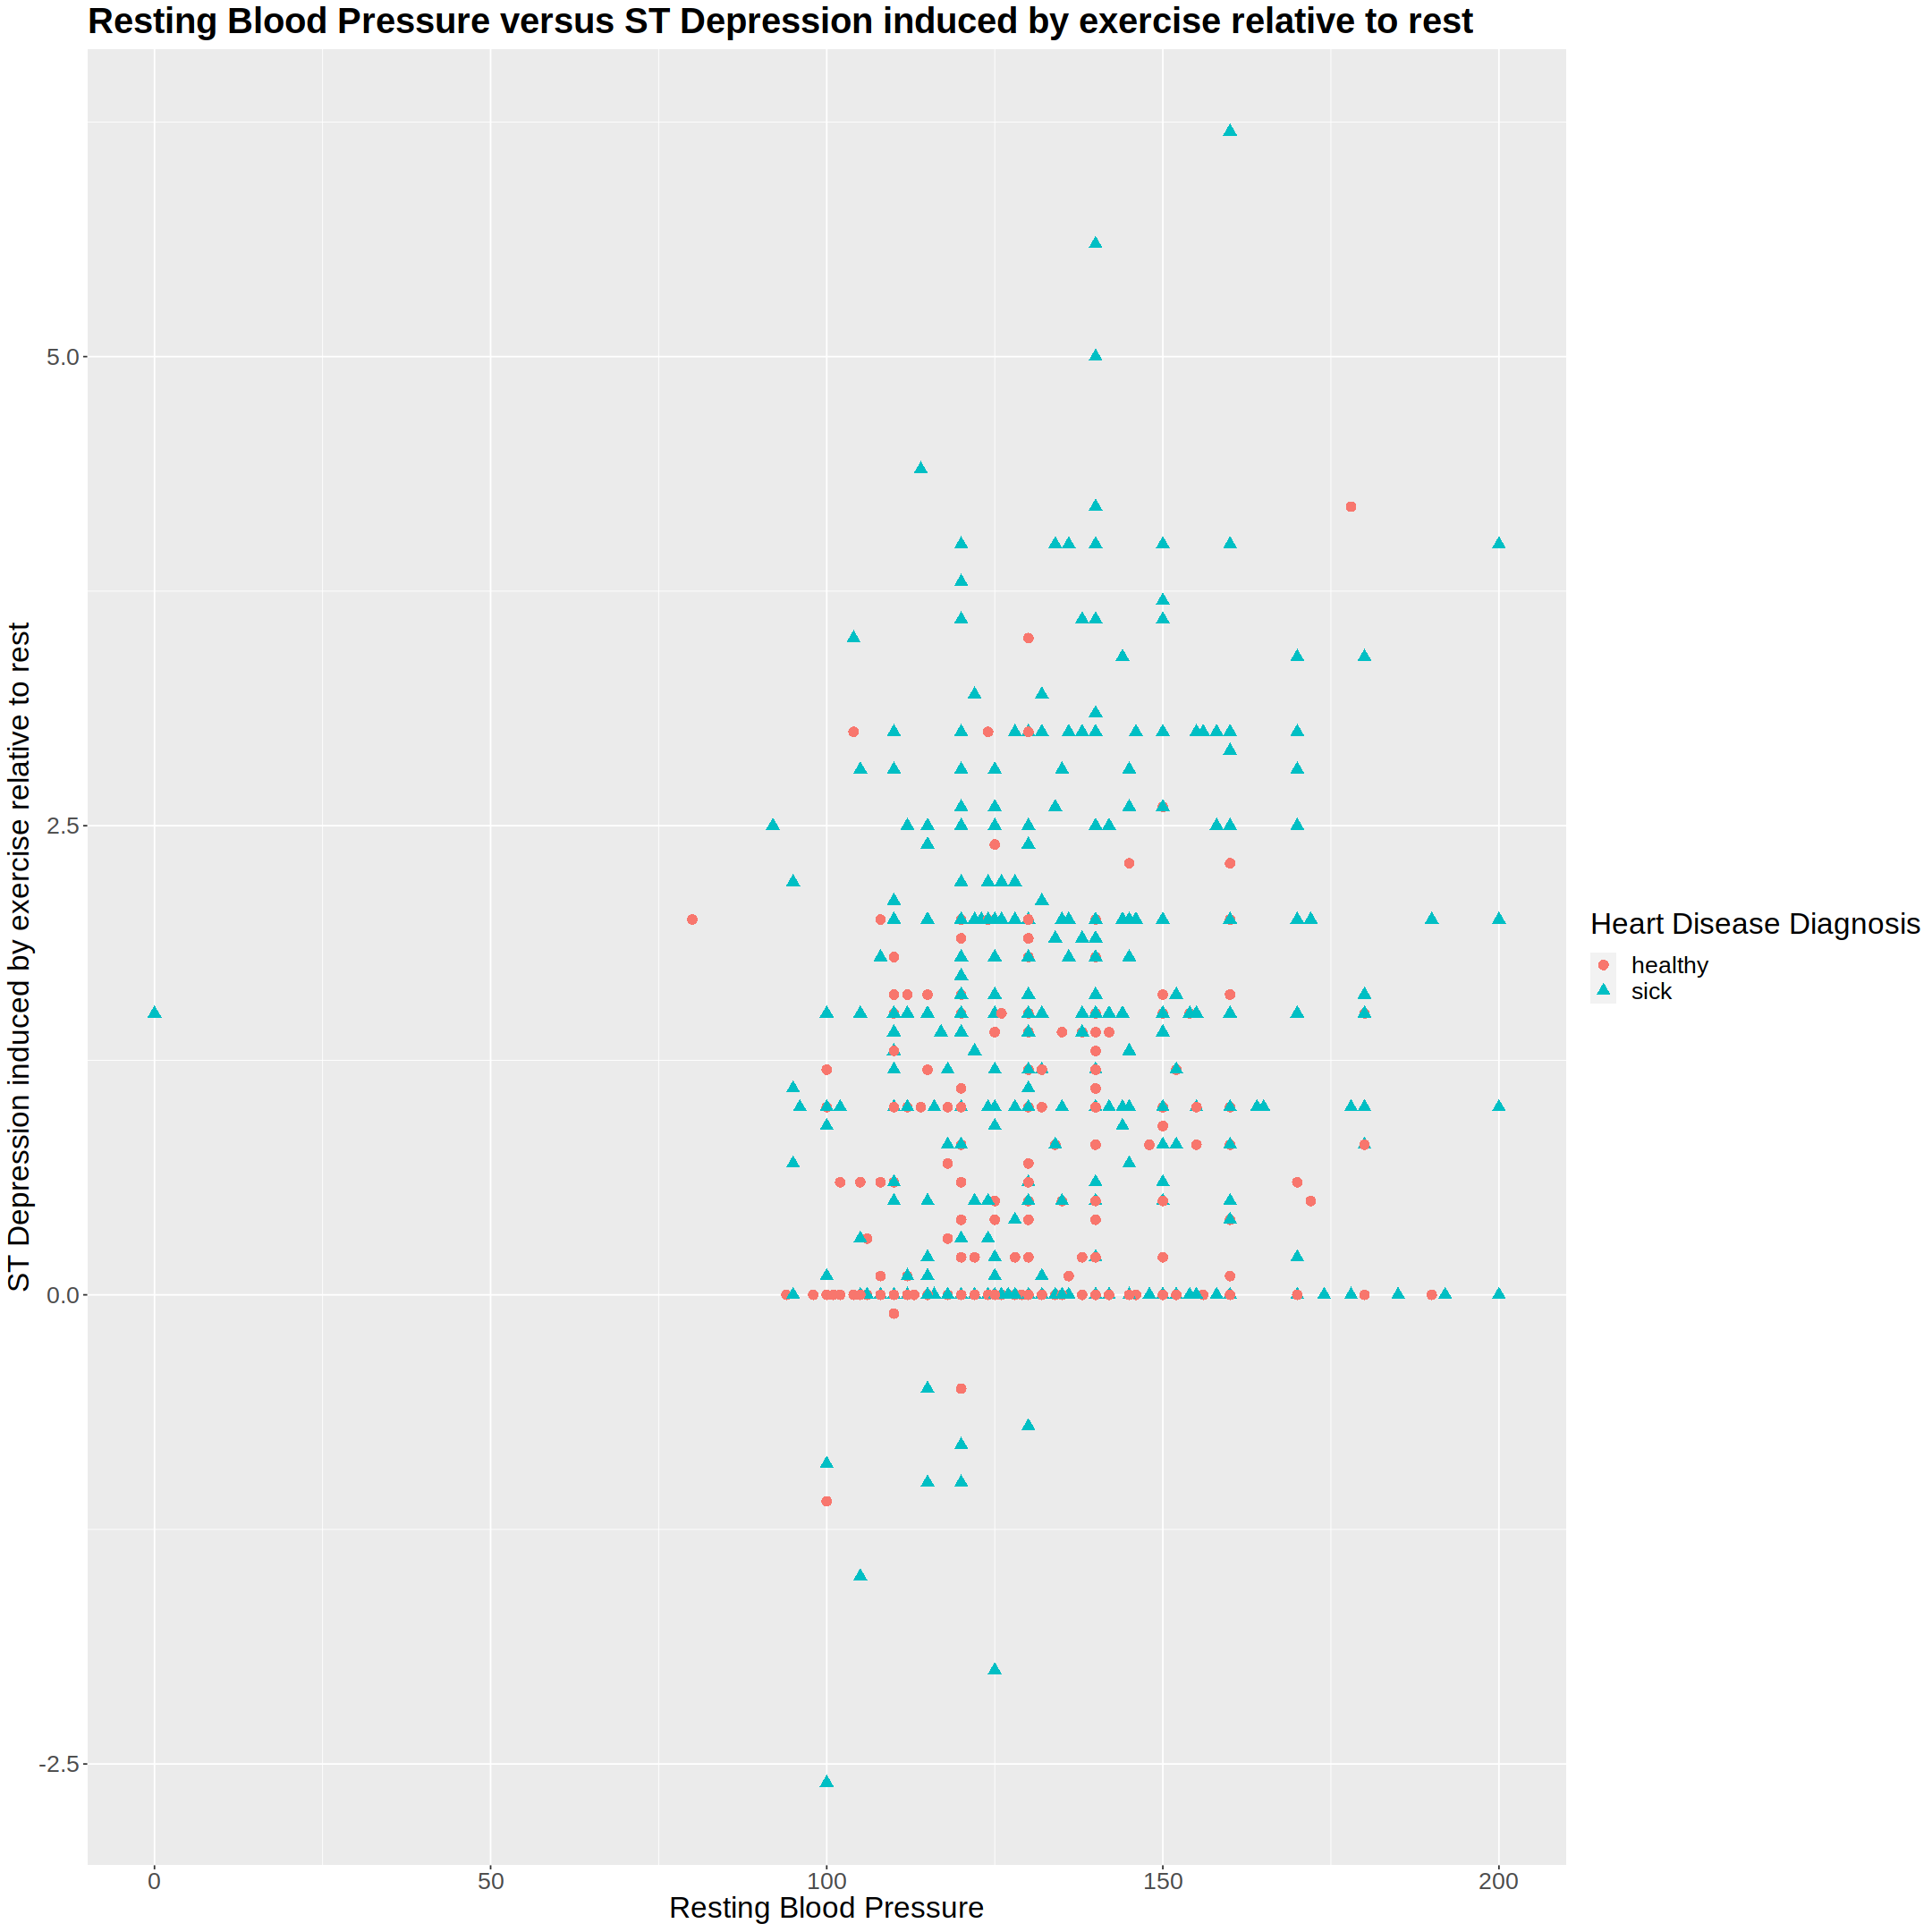

Warning message:
“Removed 82 rows containing missing values (`geom_point()`).”


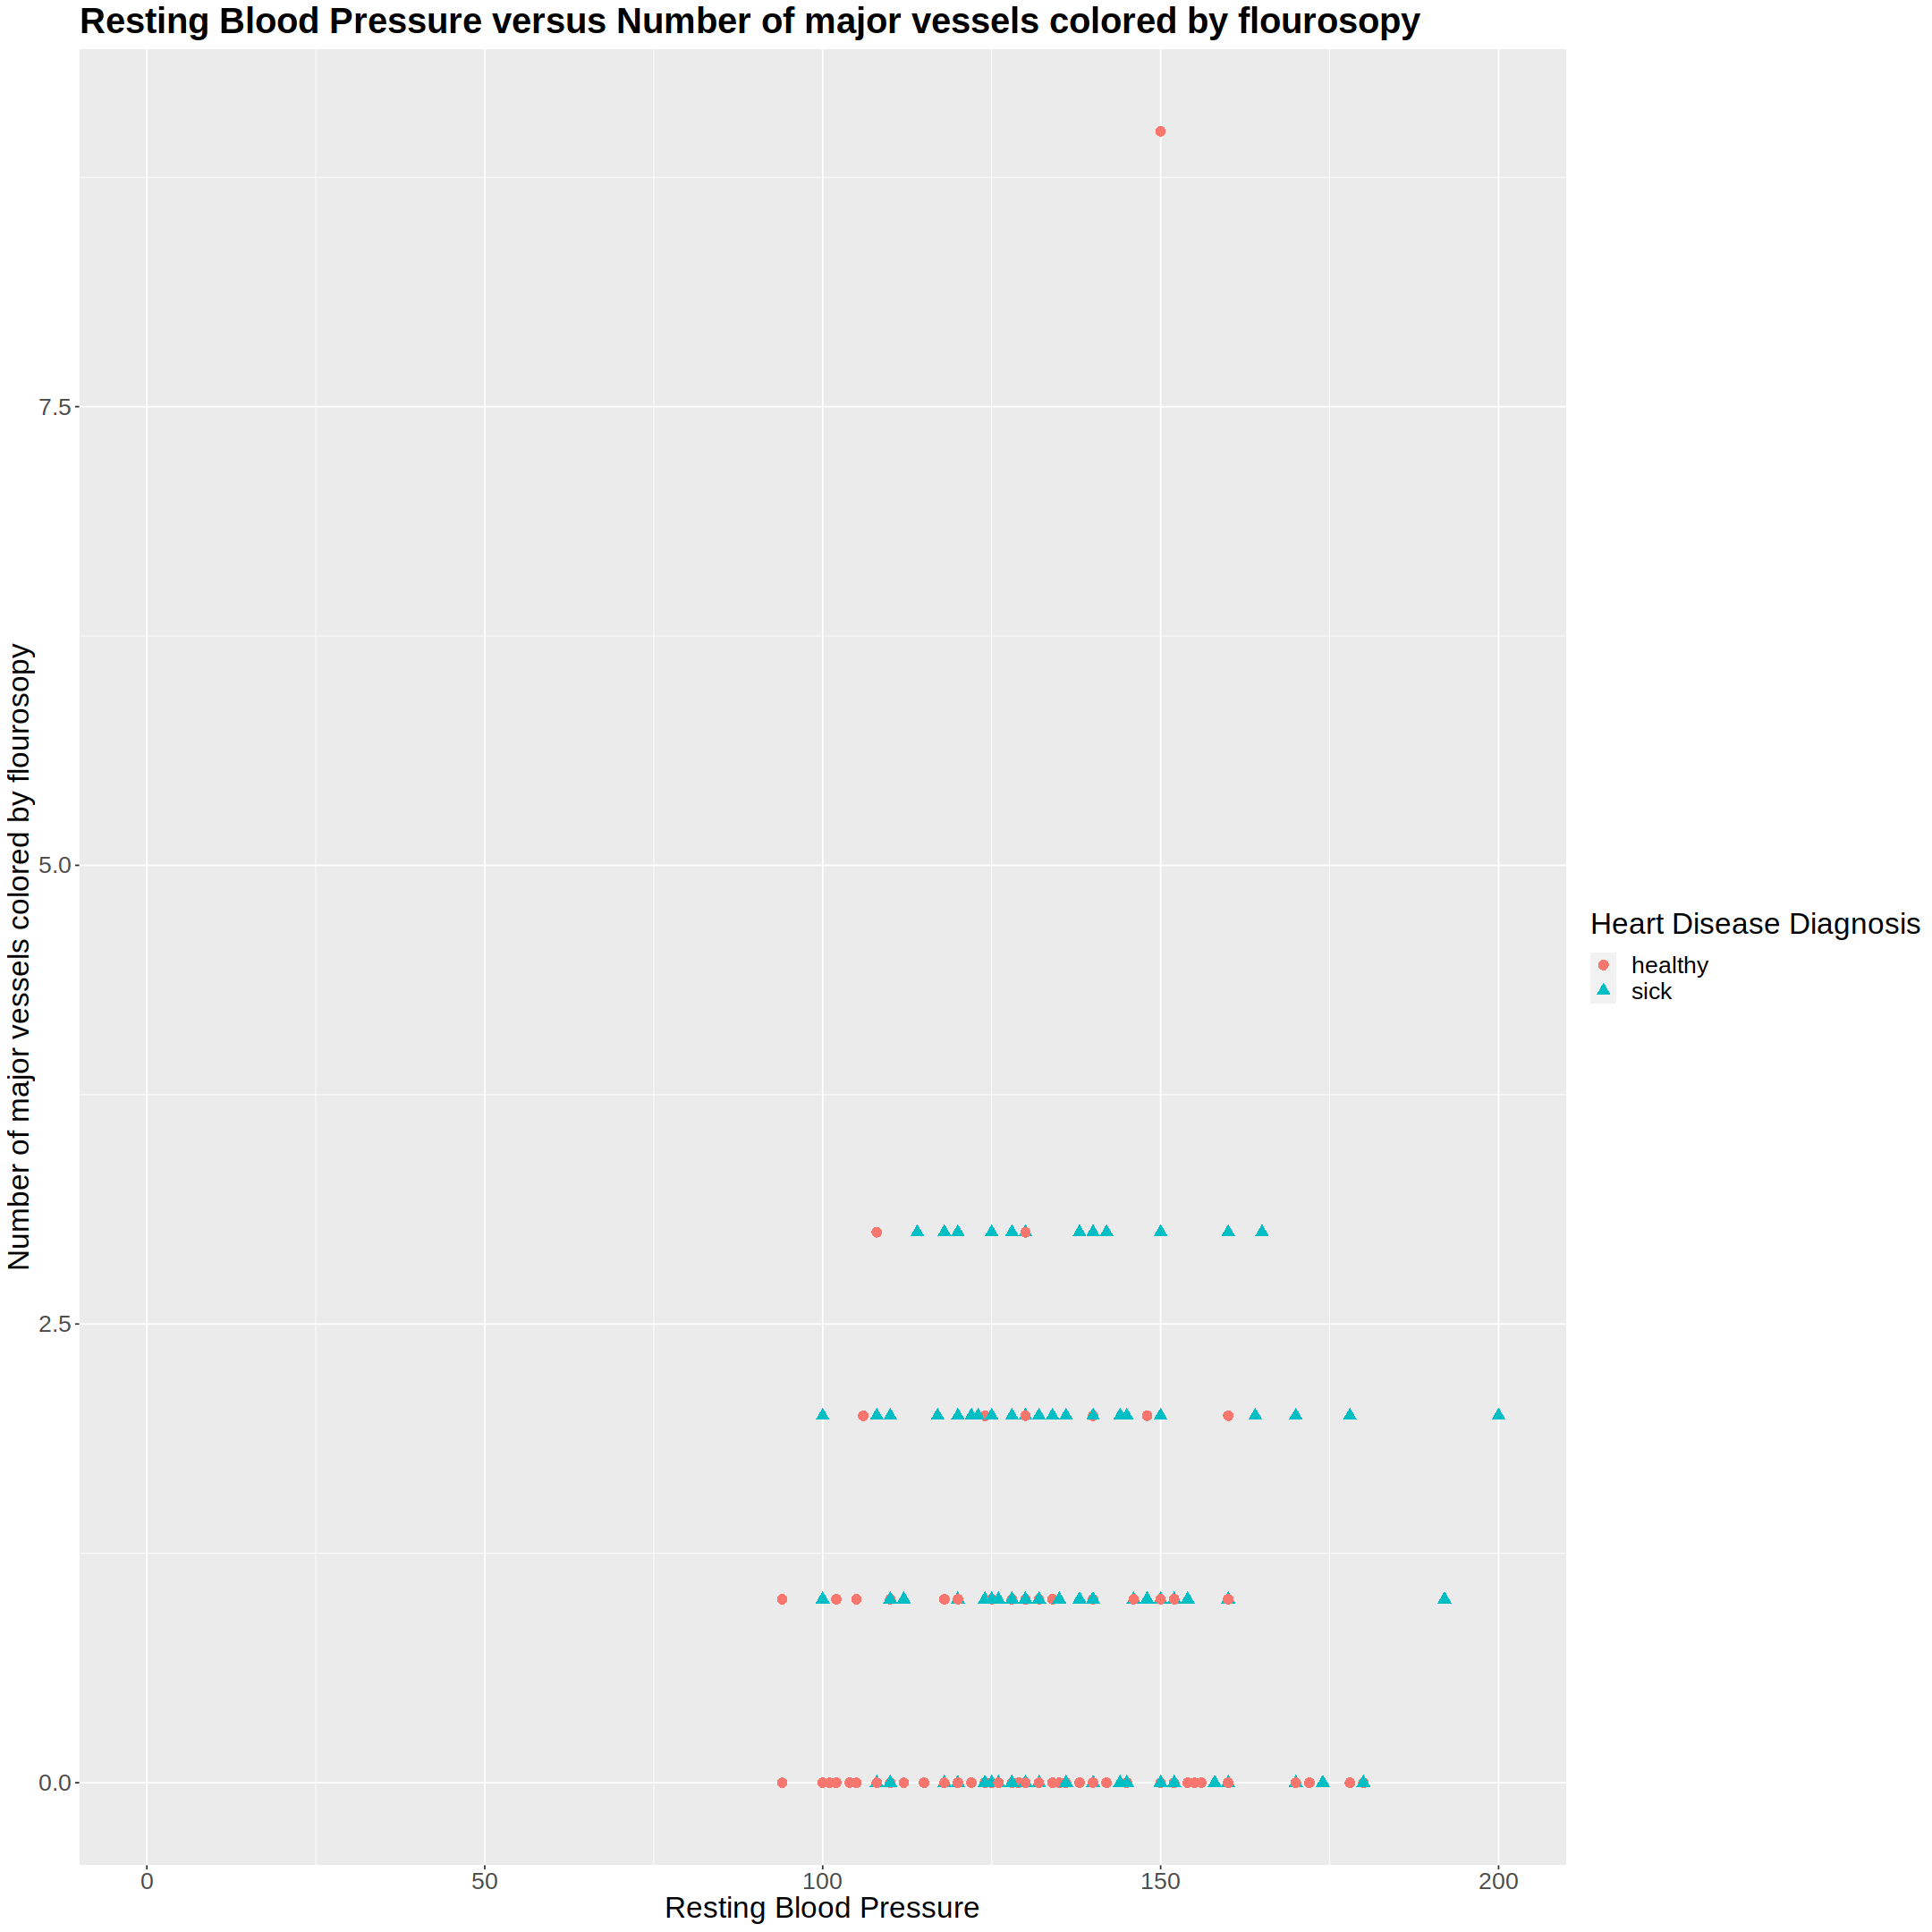

Warning message:
“Removed 89 rows containing missing values (`geom_point()`).”


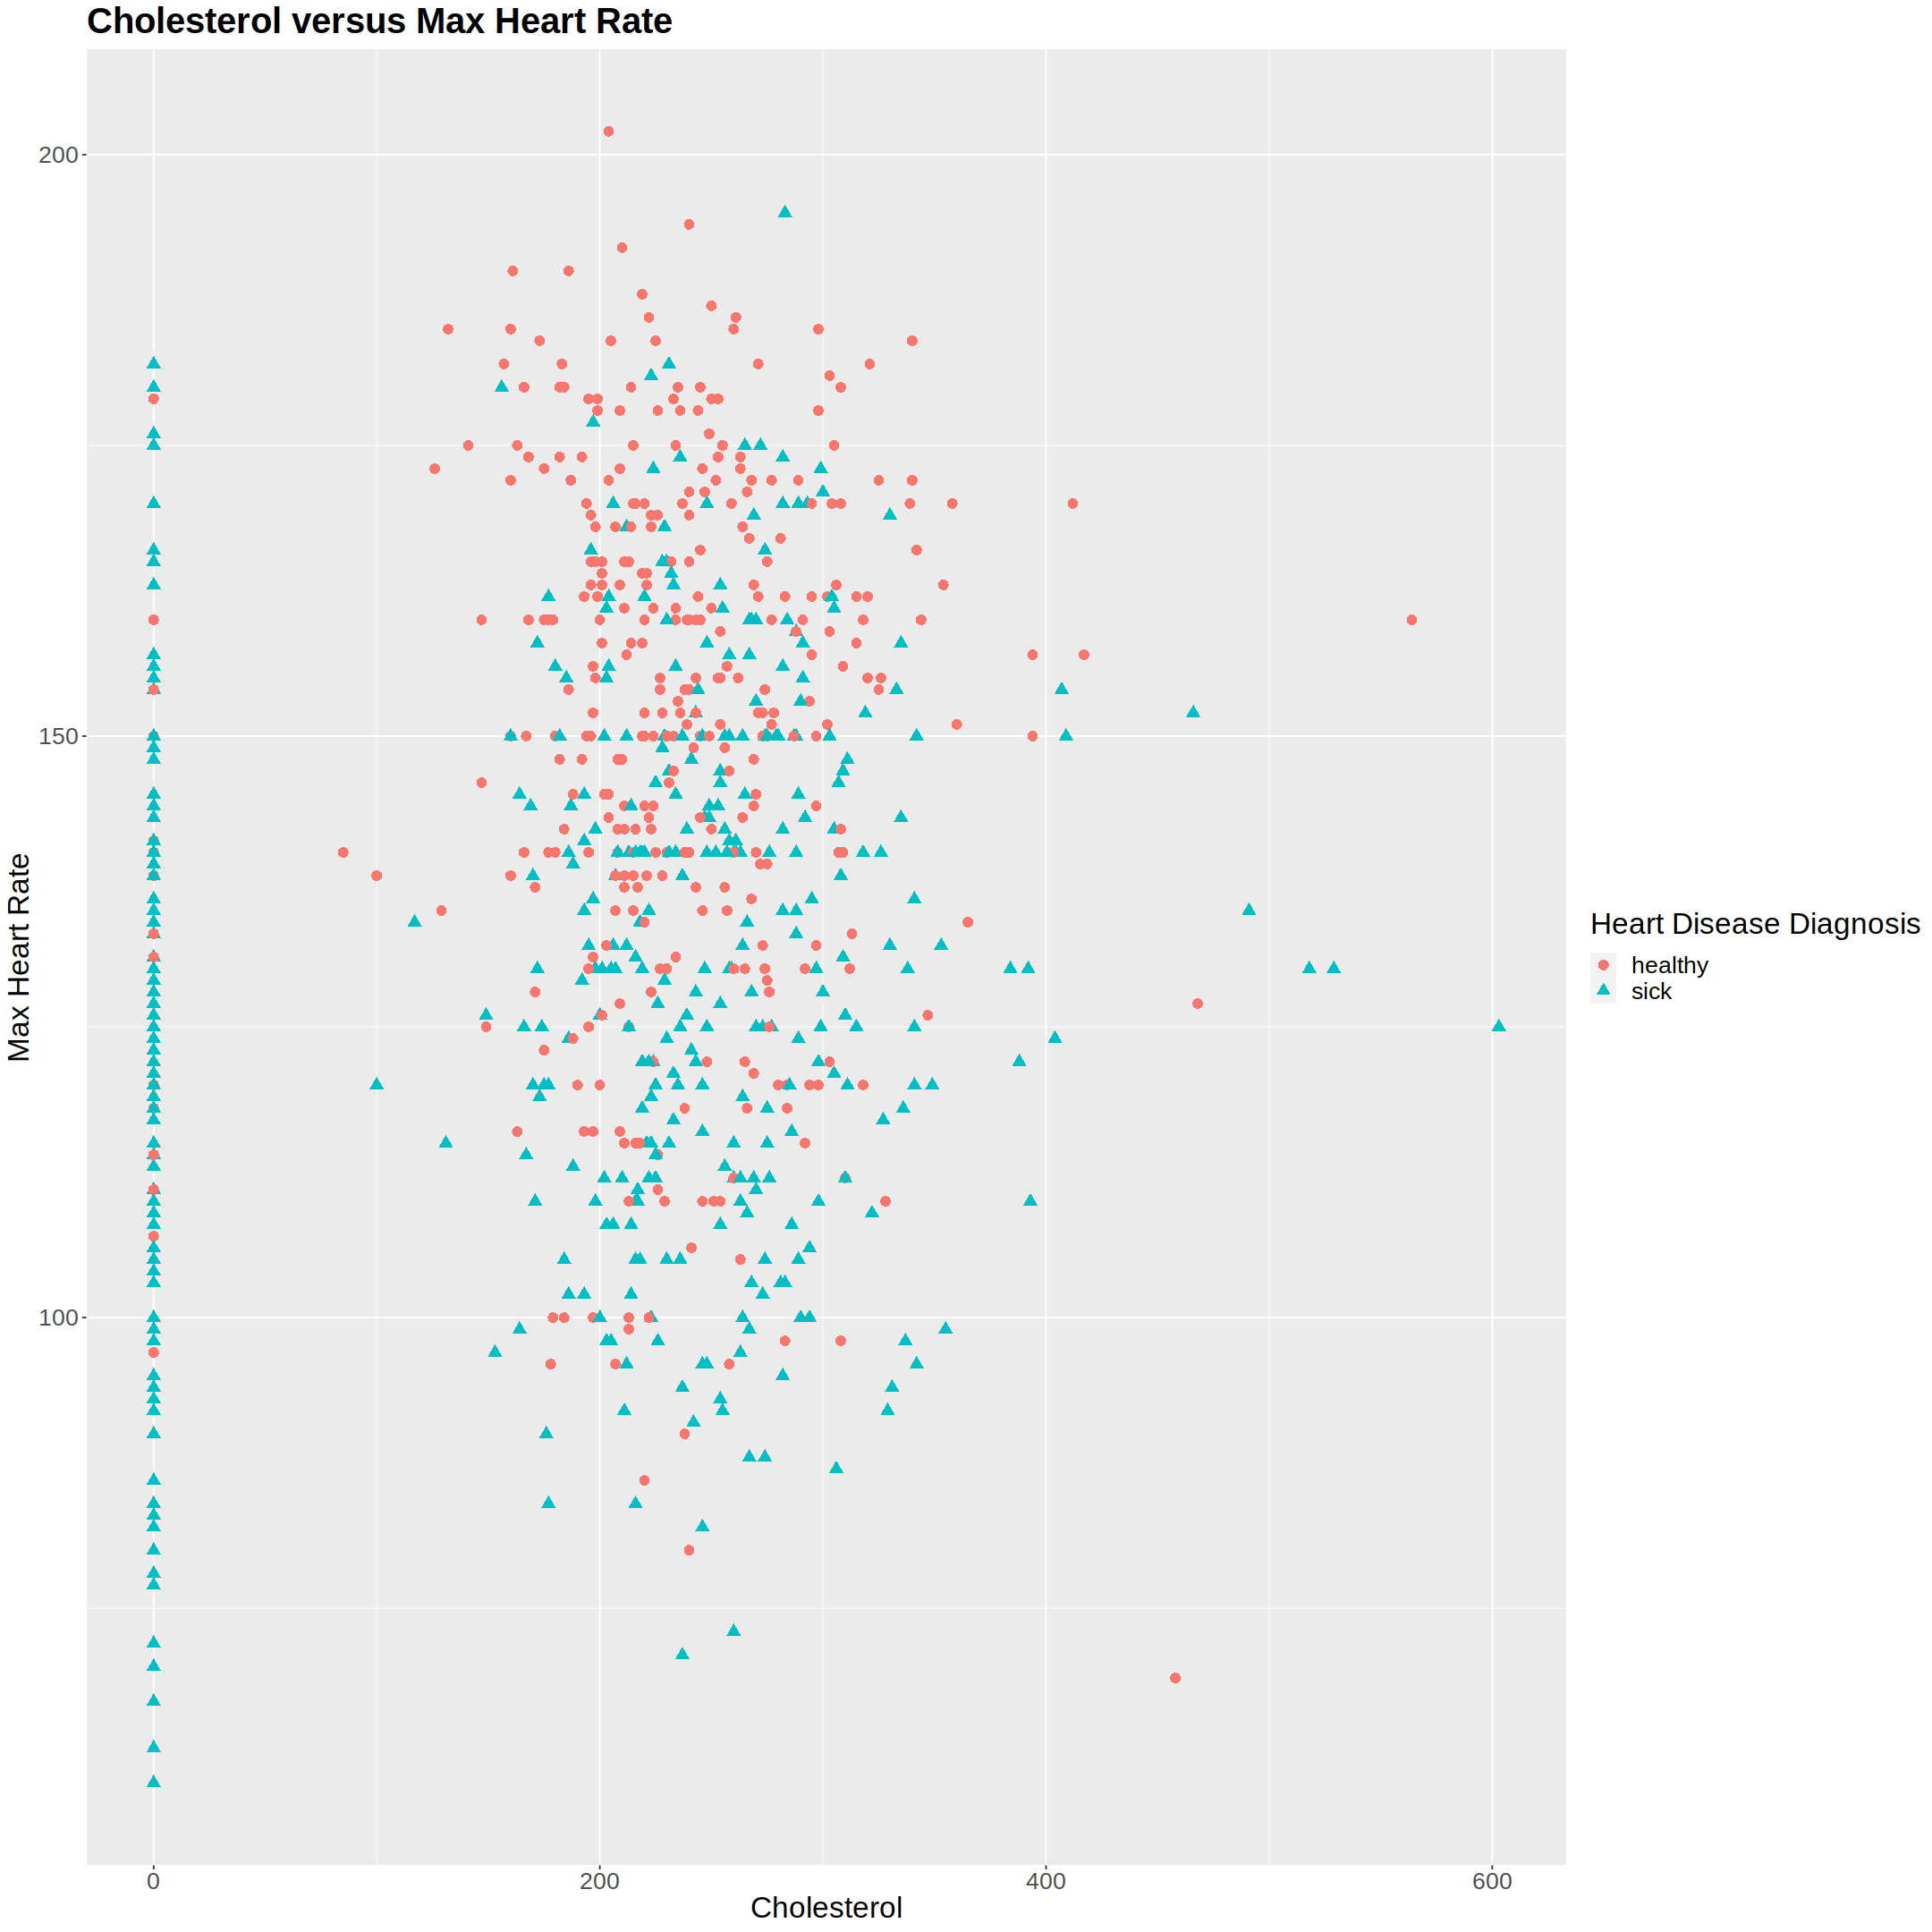

Warning message:
“Removed 611 rows containing missing values (`geom_point()`).”


In [ ]:
options(repr.plot.width = 18, repr.plot.height = 18) 

# coloured and grouped-by-shape scatterplot

# Age & Resting_Blood_Pressure 
age_rbp <- global_dataset |> 
    ggplot(aes(x = Age, y = Resting_Blood_Pressure)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Age versus Resting Blood Pressure", x = "Age", y = "Resting Blood Pressure", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
age_rbp

# Age & Cholesterol 
age_chol <- global_dataset |> 
    ggplot(aes(x = Age, y = Cholesterol)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Age versus Cholesterol", x = "Age", y = "Cholesterol", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
age_chol

# Age & Max_heart_rate
age_maxhr <- global_dataset |> 
    ggplot(aes(x = Age, y = Max_heart_rate)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Age versus Max Heart Rate", x = "Age", y = "Max Heart Rate", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
age_maxhr

# Age & ST_depression_induced_by_exercise_relative_to_rest
age_oldpeak <- global_dataset |> 
    ggplot(aes(x = Age, y = ST_depression_induced_by_exercise_relative_to_rest)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Age versus ST Depression", x = "Age", y = "ST Depression", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
age_oldpeak

# Age & Number_of_major_vessels_colored_by_flourosopy
age_ca <- global_dataset |> 
    ggplot(aes(x = Age, y = Number_of_major_vessels_colored_by_flourosopy)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Age versus Number of major vessels colored by flourosopy", x = "Age", y = "Number of major vessels colored by flourosopy", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
age_ca

# Resting_Blood_Pressure & Cholesterol
rbp_chol <- global_dataset |> 
    ggplot(aes(x = Resting_Blood_Pressure, y = Cholesterol)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Resting Blood Pressure versus Cholesterol", x = "Resting Blood Pressure", y = "Cholesterol", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
rbp_chol

# Resting_Blood_Pressure & Max_heart_rate
rbp_mhr <- global_dataset |> 
    ggplot(aes(x = Resting_Blood_Pressure, y = Max_heart_rate)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Resting Blood Pressure versus Max Heart Rate", x = "Resting Blood Pressure", y = "Max Heart Rate", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
rbp_mhr

# Resting_Blood_Pressure & ST_depression_induced_by_exercise_relative_to_rest
rbp_oldpeak <- global_dataset |> 
    ggplot(aes(x = Resting_Blood_Pressure, y = ST_depression_induced_by_exercise_relative_to_rest)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Resting Blood Pressure versus ST Depression induced by exercise relative to rest", x = "Resting Blood Pressure", y = "ST Depression induced by exercise relative to rest", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
rbp_oldpeak

# Resting_Blood_Pressure & Number_of_major_vessels_colored_by_flourosopy
rbp_ca <- global_dataset |> 
    ggplot(aes(x = Resting_Blood_Pressure, y = Number_of_major_vessels_colored_by_flourosopy)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Resting Blood Pressure versus Number of major vessels colored by flourosopy", x = "Resting Blood Pressure", y = "Number of major vessels colored by flourosopy", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
rbp_ca

# Cholesterol & Max_heart_rate
chol_mhr <- global_dataset |> 
    ggplot(aes(x = Cholesterol, y = Max_heart_rate)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Cholesterol versus Max Heart Rate", x = "Cholesterol", y = "Max Heart Rate", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
chol_mhr

# Cholesterol & ST_depression_induced_by_exercise_relative_to_rest
chol_oldpeak <- global_dataset |> 
    ggplot(aes(x = Cholesterol, y = ST_depression_induced_by_exercise_relative_to_rest)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Cholesterol versus ST depression induced by exercise relative to rest", x = "Cholesterol", y = "ST depression induced by exercise relative to rest", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
chol_oldpeak

# Cholesterol & Number_of_major_vessels_colored_by_flourosopy
chol_ca <- global_dataset |> 
    ggplot(aes(x = Cholesterol, y = Number_of_major_vessels_colored_by_flourosopy)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Cholesterol versus Number of major vessels colored by flourosopy", x = "Cholesterol", y = "Number of major vessels colored by flourosopy", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
chol_ca

# Max_heart_rate & ST_depression_induced_by_exercise_relative_to_rest
mhr_oldpeak <- global_dataset |> 
    ggplot(aes(x = Max_heart_rate, y = ST_depression_induced_by_exercise_relative_to_rest)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Max Heart Rate versus ST Depression induced by exercise relative to rest", x = "Cholesterol", y = "ST Depression induced by exercise relative to rest", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
mhr_oldpeak

# Max_heart_rate & Number_of_major_vessels_colored_by_flourosopy
mhr_ca <- global_dataset |> 
    ggplot(aes(x = Max_heart_rate, y = Number_of_major_vessels_colored_by_flourosopy)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "Max Heart Rate versus Number of major vessels colored by flourosopy", x = "Max Heart Rate", y = "Number of major vessels colored by flourosopy", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
mhr_ca

# ST_depression_induced_by_exercise_relative_to_rest & Number_of_major_vessels_colored_by_flourosopy
oldpeak_ca <- global_dataset |> 
    ggplot(aes(x = ST_depression_induced_by_exercise_relative_to_rest, y = Number_of_major_vessels_colored_by_flourosopy)) + 
    geom_point(aes(colour = Class, shape = Class), size = 3) + 
    labs(title = "ST depression induced by exercise relative to rest versus Number of major vessels colored by flourosopy", x = "ST depression induced by exercise relative to rest", y = "Number of major vessels colored by flourosopy", colour = "Heart Disease Diagnosis", shape = "Heart Disease Diagnosis") + 
    theme(text = element_text(size = 20), plot.title = element_text(face = "bold"))
oldpeak_ca

# Methods #

## Explain how you will conduct either your data analysis and which variables/columns you will use. ##

K-nearest neighbors algorithm will be used to predict if a patient is healthy or sick based on their ST depression induced by exercise relative to rest and their maximum heart rate. <br> 
Other variables like cholesterol and resting blood pressure were considered to be used for the classification model, but after plotting each of the variables against each other in scatterplots, <br> 
it appeared that the ST depression vs maximum heart rate best clustered the data into sick and healthy groups.



## Describe at least one way that you will visualize the results ##

A scatterplot will be used to plot St depression induced by exercise relative to rest and their maximum heart rate. <br>
The points will be colored and shaped based on sick vs. healthy to make the plot easier to read/ interpret.




In [ ]:
# Expected outcomes and significance #

## What do you expect to find? ##
This study aims to propose an accurate classification model for heart disease prediction using a machine learning classification algorithm, K-nearest neighbors.

## What impact could such findings have? ##
The findings of this study could have the potential to make an impact in the field of medical health since an accurate heart disease prediction model can assist intervention measures, which may lead to better patient outcomes.

## What future questions could this lead to? ##
Future questions that this could raise involve the comparability of the K-nearest neighbors classifier model to other models. <br> For example, how does the accuracy of prediction with the K-nearest neighbors approach compared with other prediction models based on different machine learning algorithms? <br> What are the advantages and limitations of the K-nearest neighbors method in comparison to the other methods in the case of predicting the heart disease? <br> Moreover, since this study will be using region-specific data, another potential future question is: how well does this model predict heart disease across diverse populations and geographic regions?